In [44]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Imbalance Handling & Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline # Use imblearn's Pipeline for SMOTE compatibility

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron

# Calibration
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Metrics & Plotting
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, brier_score_loss, f1_score,
                             accuracy_score, RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay)

# Data Preprocessing

In [45]:
# Data Loading and Initial Cleaning
file_path = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv" # Use the correct path
try:
    car_insurance_data = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from: {file_path}")
    print(f"Initial shape: {car_insurance_data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- Currency Column Conversion ---
currency_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
print(f"\nConverting currency columns: {currency_cols}")
for col in currency_cols:
    if col in car_insurance_data.columns:
        car_insurance_data[col] = car_insurance_data[col].replace('[\$,]', '', regex=True)
        car_insurance_data[col] = pd.to_numeric(car_insurance_data[col], errors='coerce')
    else:
         print(f"Warning: Currency column '{col}' not found.")
print("Currency columns converted to numeric (errors coerced to NaN).")

# --- Handle Missing Values ---
initial_rows = car_insurance_data.shape[0]
car_insurance_data_clean = car_insurance_data.dropna()
rows_dropped = initial_rows - car_insurance_data_clean.shape[0]
print(f"\nRemoved {rows_dropped} rows with NaN values.")
print(f"Shape after dropna: {car_insurance_data_clean.shape}")

Dataset loaded successfully from: /Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv
Initial shape: (10302, 25)

Converting currency columns: ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
Currency columns converted to numeric (errors coerced to NaN).

Removed 2645 rows with NaN values.
Shape after dropna: (7657, 25)


In [46]:
#  Define Exclusions and Drop Columns (Ethicality)
target_variable = 'CLAIM_FLAG'

# Check if target exists before proceeding
if target_variable not in car_insurance_data_clean.columns:
    print(f"Error: Target variable '{target_variable}' not found after cleaning.")
    exit()
print(f"Target variable '{target_variable}' identified.")


# --- Define Columns to Exclude (includes target, ID, ethical exclusions) ---
columns_to_exclude = [
    target_variable, # Exclude target from features later, keep for now
    'ID',            # Exclude ID
    'GENDER',
    'MSTATUS',
    'PARENT1',
    'EDUCATION',
    'URBANICITY',
    'OCCUPATION',
    'CLM_AMT'
]
# Find which ones actually exist in the current dataframe
columns_to_exclude_existing = [col for col in columns_to_exclude if col in car_insurance_data_clean.columns]
# We will drop all except the target variable now. Target is dropped when defining X.
columns_to_drop_now = [col for col in columns_to_exclude_existing if col != target_variable]

print(f"\nColumns specified for exclusion (dropping before encoding/feature definition): {columns_to_drop_now}")

# --- Drop the exclusion columns (except target) ---
car_insurance_features_pre = car_insurance_data_clean.drop(columns=columns_to_drop_now)
print(f"Columns dropped. Shape before encoding: {car_insurance_features_pre.shape}")

Target variable 'CLAIM_FLAG' identified.

Columns specified for exclusion (dropping before encoding/feature definition): ['GENDER', 'MSTATUS', 'PARENT1', 'EDUCATION', 'URBANICITY', 'OCCUPATION', 'CLM_AMT']
Columns dropped. Shape before encoding: (7657, 18)


In [47]:
# One-Hot Encode REMAINING Categorical Columns ---
categorical_cols_remaining = car_insurance_features_pre.select_dtypes(include=['object']).columns.tolist()
print(f"\nOne-hot encoding remaining categorical columns: {categorical_cols_remaining}")

car_insurance_encoded = pd.get_dummies(car_insurance_features_pre,
                                           columns=categorical_cols_remaining,
                                           drop_first=True)
print(car_insurance_encoded.head(3))
print(f"Shape after encoding (if any): {car_insurance_encoded.shape}")

# --- Define Final Target (y) and Feature Matrix (X) ---
# y was defined from the clean data before dropping columns, but let's redefine from the potentially encoded df to ensure alignment
y = car_insurance_encoded[target_variable]
print(f"\nFinal Target variable '{target_variable}' defined.")

# X is now the encoded dataframe minus the target variable
X = car_insurance_encoded.drop(columns=[target_variable])
print(f"Final Feature matrix (X) created.")
print(f"Shape of Feature Matrix (X): {X.shape}")
print(f"Shape of Target Vector (y): {y.shape}")


One-hot encoding remaining categorical columns: ['CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED']
   KIDSDRIV   AGE  HOMEKIDS   YOJ   INCOME  HOME_VAL  TRAVTIME  BLUEBOOK  TIF  \
0         0  60.0         0  11.0  67349.0       0.0        14     14230   11   
1         0  43.0         0  11.0  91449.0  257252.0        22     14940    1   
2         0  48.0         0  11.0  52881.0       0.0        26     21970    1   

   OLDCLAIM  ...  CAR_AGE  CLAIM_FLAG  CAR_USE_Private  CAR_TYPE_Panel Truck  \
0      4461  ...     18.0           0             True                 False   
1         0  ...      1.0           0            False                 False   
2         0  ...     10.0           0             True                 False   

   CAR_TYPE_Pickup  CAR_TYPE_Sports Car  CAR_TYPE_Van  CAR_TYPE_z_SUV  \
0            False                False         False           False   
1            False                False         False           False   
2            False                False 

# Split Train-Test

In [48]:
# Splitting Data (Train / Test)
# We only need Train/Test split now, as CV within CalibratedClassifierCV handles the calibration part.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Data Shapes After Splitting:")
print(f"Train Set: X={X_train.shape}, y={y_train.shape}")
print(f"Test Set:  X={X_test.shape}, y={y_test.shape}")
print("\nClass distribution in Original Training Set:")
print(y_train.value_counts(normalize=True))


# --- Demonstrate SMOTE effect on the overall Training set ---.
smote_demonstration = SMOTE(random_state=42)
X_train_smote_demo, y_train_smote_demo = smote_demonstration.fit_resample(X_train, y_train)

print("Data Shapes After SMOTE (Demonstration):")
print(f"X_train_smote_demo={X_train_smote_demo.shape}, y_train_smote_demo={y_train_smote_demo.shape}")
print("\nClass distribution AFTER SMOTE (Demonstration):")

print(pd.Series(y_train_smote_demo).value_counts(normalize=True))


Data Shapes After Splitting:
Train Set: X=(5742, 21), y=(5742,)
Test Set:  X=(1915, 21), y=(1915,)

Class distribution in Original Training Set:
CLAIM_FLAG
0    0.731104
1    0.268896
Name: proportion, dtype: float64
Data Shapes After SMOTE (Demonstration):
X_train_smote_demo=(8396, 21), y_train_smote_demo=(8396,)

Class distribution AFTER SMOTE (Demonstration):
CLAIM_FLAG
0    0.5
1    0.5
Name: proportion, dtype: float64


In [49]:
# Model Training, Calibration (with CV), and Evaluation Setup
# Define Cross-Validation Strategy ---
# Stratified K-Fold is good for classification with imbalance
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print(f"\nUsing CV Strategy: {cv_strategy}")

# --- Helper function for Reliability Plot ---
# Ensure matplotlib.pyplot was imported as plt previously
def plot_reliability_curve(y_true, y_prob, model_name, ax):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
    ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
    ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Calibrated)')
    ax.set_xlabel("Mean Predicted Probability (bin)")
    ax.set_ylabel("Fraction of Positives (bin)")
    ax.set_title("Reliability Curve")
    ax.legend()
    ax.grid(True)
print("Helper function for reliability plot defined.")

# --- Function to Evaluate Model (to reduce repetition) ---
# Ensure all necessary metric functions and display classes were imported previously
def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n--- Evaluating Calibrated {model_name} on Test Set ---")
    # CalibratedClassifierCV handles internal scaling predictions if pipeline includes scaler
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_class = model.predict(X_test)

    # Classification Metrics
    print(f"\nClassification Report ({model_name}):")
    print(classification_report(y_test, y_pred_class, target_names=['No Claim (0)', 'Claim (1)']))

    # Calculate and Print Metrics
    acc = accuracy_score(y_test, y_pred_class)
    f1_minority = f1_score(y_test, y_pred_class, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    brier_score = brier_score_loss(y_test, y_pred_proba)

    print(f"\nAccuracy Score: {acc:.4f}")
    print(f"F1 Score (Claim=1): {f1_minority:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"PR AUC: {pr_auc:.4f}")
    print(f"Brier Score Loss: {brier_score:.4f}")

    # Plots
    fig, axes = plt.subplots(1, 4, figsize=(28, 6)) # Increased figure size for 4 plots

    # Confusion Matrix Plot
    cm_display = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred_class, display_labels=['No Claim (0)', 'Claim (1)'],
        ax=axes[0], cmap=plt.cm.Blues
    )
    axes[0].set_title(f'Confusion Matrix ({model_name})')

    # ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_pred_proba, ax=axes[1], name=model_name)
    axes[1].set_title('ROC Curve'); axes[1].grid(True)

    # Precision-Recall Curve
    PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=axes[2], name=model_name)
    axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)

    # Reliability Curve
    plot_reliability_curve(y_test, y_pred_proba, model_name, axes[3]) # Use helper function

    plt.suptitle(f'{model_name} Evaluation Plots', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show() # Show plots for this model

    print(f"\n--- Finished {model_name} ---")
print("Evaluation helper function defined.")


Using CV Strategy: StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
Helper function for reliability plot defined.
Evaluation helper function defined.


# Logistic Regression


=== Logistic Regression ===
Fitting Calibrated Logistic Regression with CV...
Fitting complete.

--- Evaluating Calibrated Logistic Regression on Test Set ---

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

No Claim (0)       0.78      0.94      0.85      1400
   Claim (1)       0.63      0.28      0.38       515

    accuracy                           0.76      1915
   macro avg       0.70      0.61      0.62      1915
weighted avg       0.74      0.76      0.73      1915


Accuracy Score: 0.7614
F1 Score (Claim=1): 0.3833
ROC AUC: 0.7512
PR AUC: 0.5270
Brier Score Loss: 0.1653


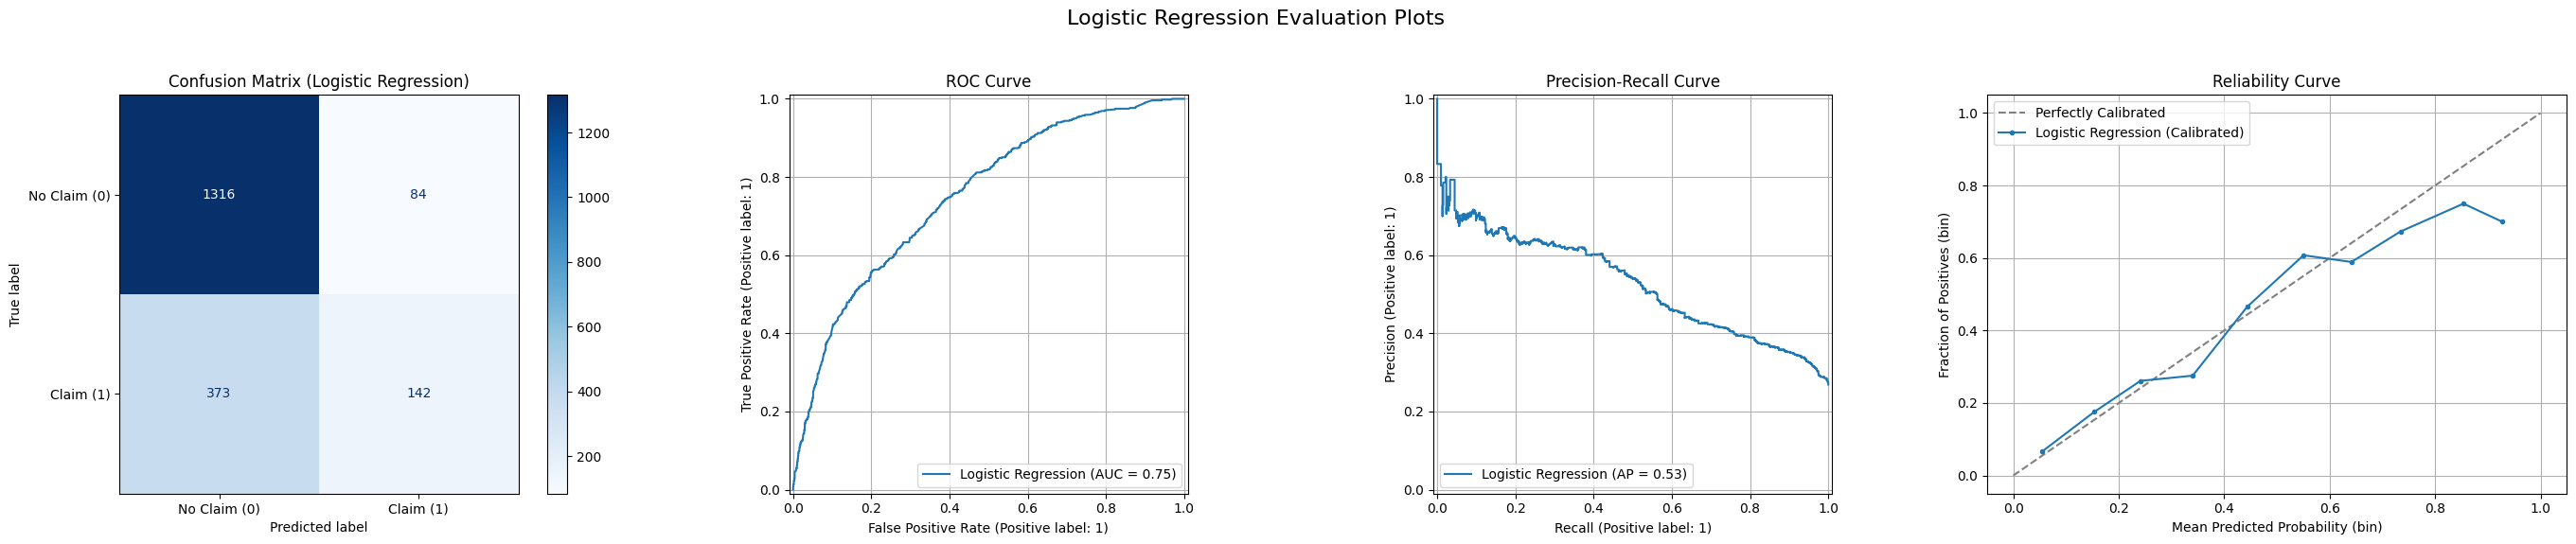


--- Finished Logistic Regression ---


In [50]:
# Logistic Regression
print("\n=== Logistic Regression ===")
# Define pipeline with scaling, SMOTE, and classifier
# Ensure StandardScaler, SMOTE, LogisticRegression are imported
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'))
])

# Define Calibrated Classifier with internal CV
# Ensure CalibratedClassifierCV is imported
calibrated_lr_cv = CalibratedClassifierCV(
    estimator=lr_pipeline,
    method='isotonic', # or 'sigmoid'
    cv=cv_strategy # Use the defined StratifiedKFold CV from Chunk 6
)

print("Fitting Calibrated Logistic Regression with CV...")
calibrated_lr_cv.fit(X_train, y_train) # Fit on the main training set from Chunk 5
print("Fitting complete.")

# Evaluate the final calibrated model using the helper function from Chunk 6
evaluate_model(calibrated_lr_cv, X_test, y_test, 'Logistic Regression')

# Random Forest


=== Random Forest ===
Fitting Calibrated Random Forest with CV...
Fitting complete.

--- Evaluating Calibrated Random Forest on Test Set ---

Classification Report (Random Forest):
              precision    recall  f1-score   support

No Claim (0)       0.78      0.92      0.84      1400
   Claim (1)       0.57      0.28      0.37       515

    accuracy                           0.75      1915
   macro avg       0.67      0.60      0.61      1915
weighted avg       0.72      0.75      0.72      1915


Accuracy Score: 0.7493
F1 Score (Claim=1): 0.3717
ROC AUC: 0.7597
PR AUC: 0.5200
Brier Score Loss: 0.1642


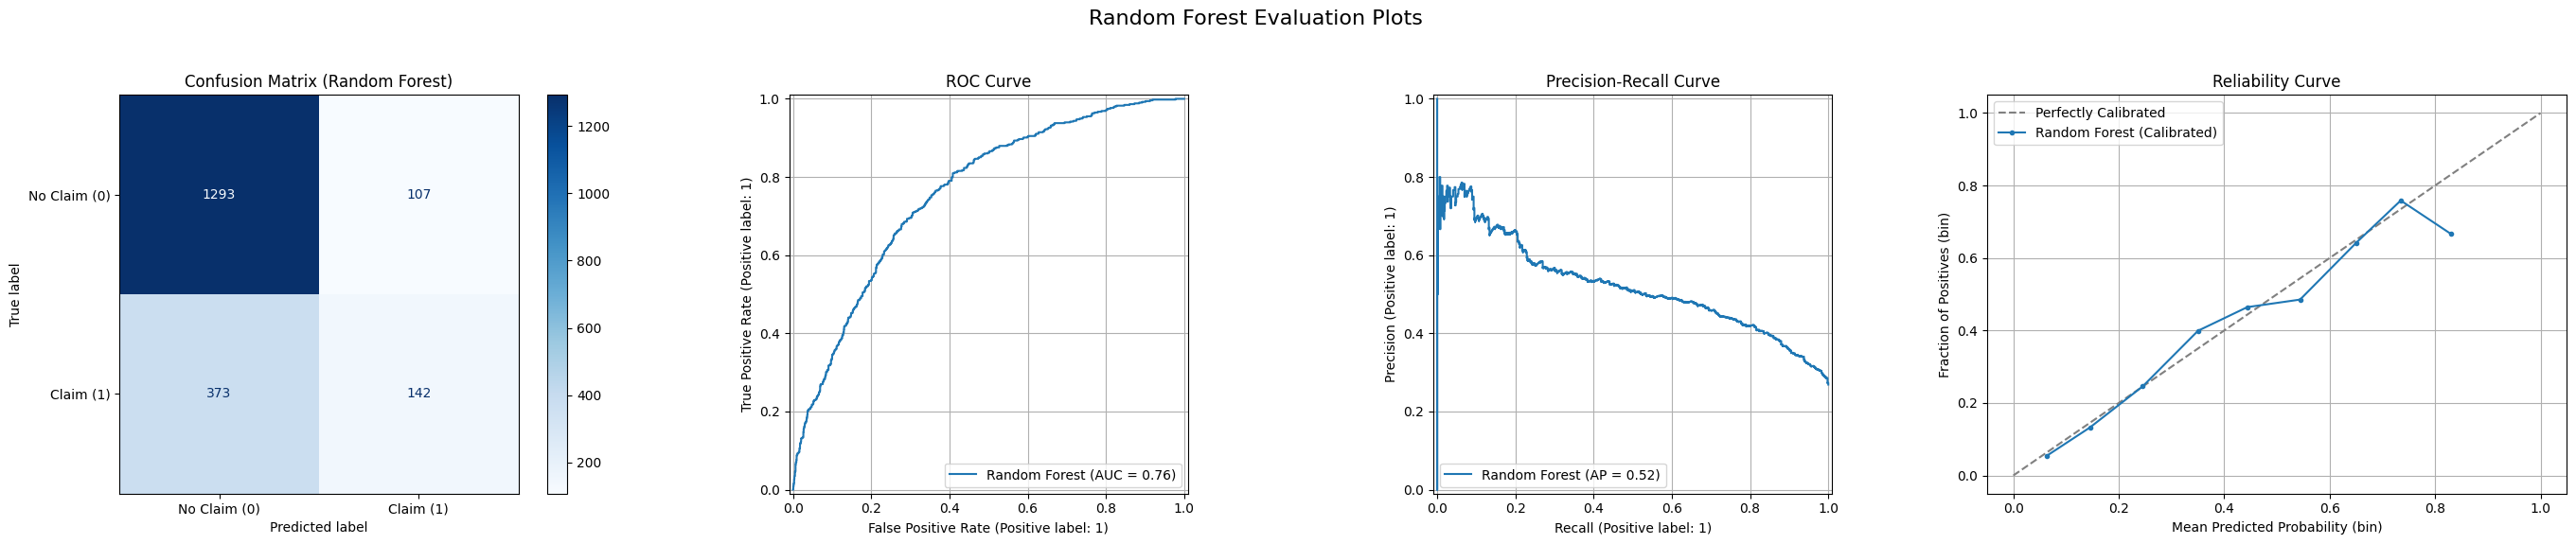


--- Finished Random Forest ---


In [51]:
# Random Forest
print("\n=== Random Forest ===")
# Define pipeline with SMOTE and classifier (NO SCALING needed for RF)
# Ensure SMOTE, RandomForestClassifier are imported
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

# Define Calibrated Classifier with internal CV
calibrated_rf_cv = CalibratedClassifierCV(
    estimator=rf_pipeline,
    method='isotonic', # or 'sigmoid'
    cv=cv_strategy # Use the defined StratifiedKFold CV from Chunk 6
)

print("Fitting Calibrated Random Forest with CV...")
calibrated_rf_cv.fit(X_train, y_train) # Fit on the main training set from Chunk 5
print("Fitting complete.")

# Evaluate the final calibrated model using the helper function from Chunk 6
evaluate_model(calibrated_rf_cv, X_test, y_test, 'Random Forest')

# Neural Network


=== Neural Network (MLP) ===
Fitting Calibrated Neural Network with CV...
Fitting complete.

--- Evaluating Calibrated Neural Network (MLP) on Test Set ---

Classification Report (Neural Network (MLP)):
              precision    recall  f1-score   support

No Claim (0)       0.77      0.95      0.85      1400
   Claim (1)       0.64      0.25      0.36       515

    accuracy                           0.76      1915
   macro avg       0.71      0.60      0.61      1915
weighted avg       0.74      0.76      0.72      1915


Accuracy Score: 0.7603
F1 Score (Claim=1): 0.3580
ROC AUC: 0.7442
PR AUC: 0.5221
Brier Score Loss: 0.1665


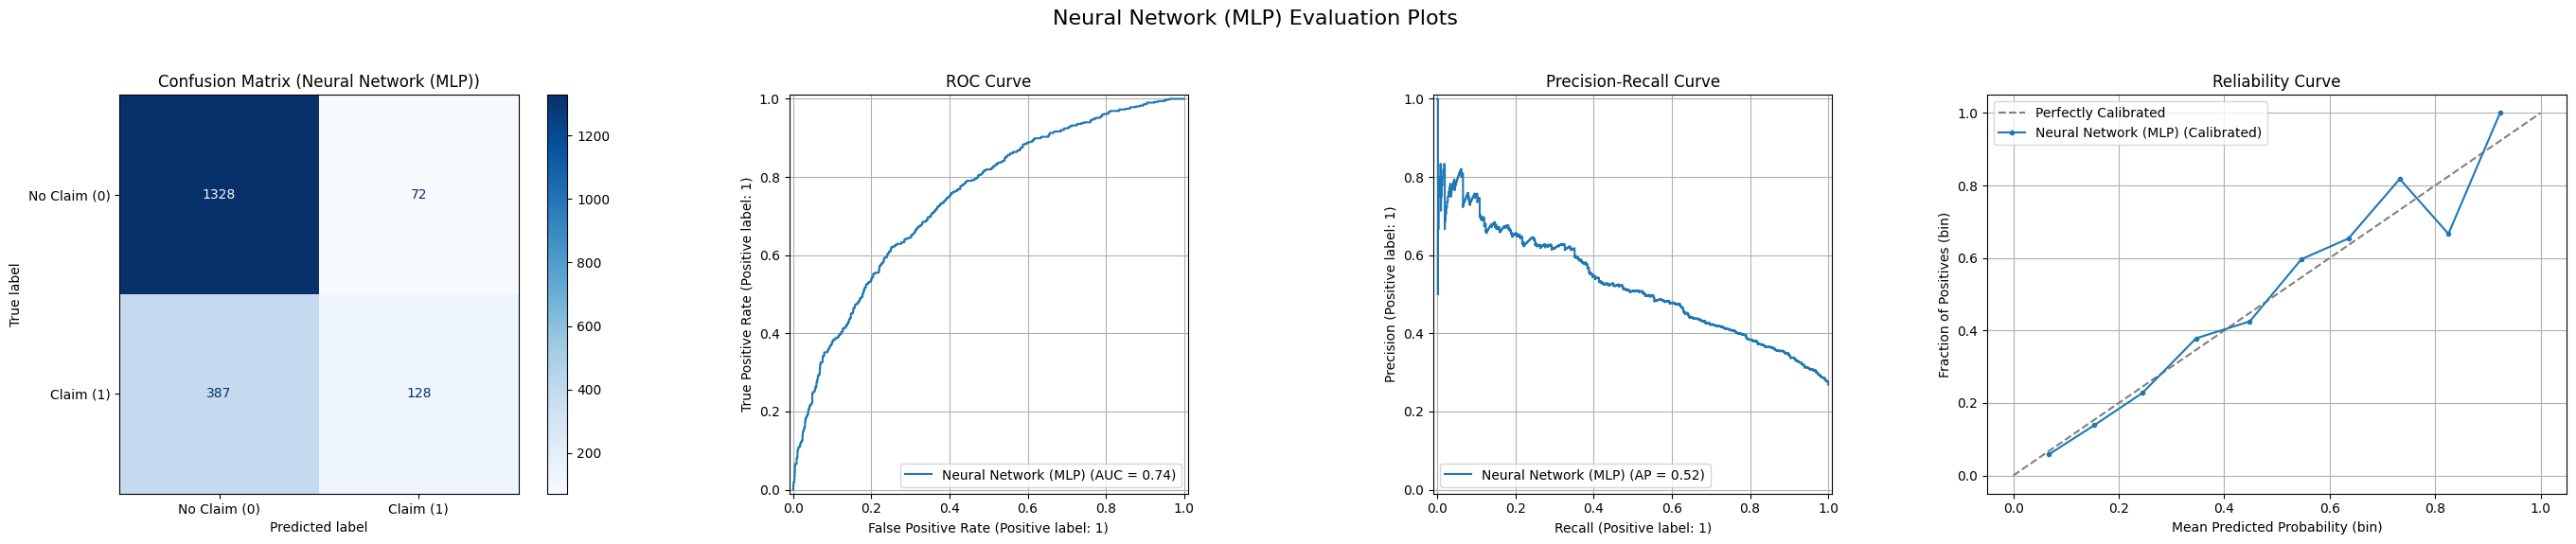


--- Finished Neural Network (MLP) ---


In [52]:
# Neural Network (MLPClassifier)

print("\n=== Neural Network (MLP) ===")
# Define pipeline with scaling, SMOTE, and classifier
# Ensure StandardScaler, SMOTE, MLPClassifier are imported
nn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam',
                                 max_iter=500, early_stopping=True, n_iter_no_change=20, # Added early stopping
                                 random_state=42, learning_rate_init=0.001))
])

# Define Calibrated Classifier with internal CV
calibrated_nn_cv = CalibratedClassifierCV(
    estimator=nn_pipeline,
    method='isotonic', # or 'sigmoid'
    cv=cv_strategy # Use the defined StratifiedKFold CV from Chunk 6
)

print("Fitting Calibrated Neural Network with CV...")
# This might take longer due to repeated NN training in CV
calibrated_nn_cv.fit(X_train, y_train) # Fit on the main training set from Chunk 5
print("Fitting complete.")

# Evaluate the final calibrated model using the helper function from Chunk 6
evaluate_model(calibrated_nn_cv, X_test, y_test, 'Neural Network (MLP)')

# Logistic Regression is the best classifier model and we will use it to complete update 3

# Fairlearn

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing & Splitting
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Imbalance Handling
from imblearn.over_sampling import SMOTE

# Model
from sklearn.linear_model import LogisticRegression

# Fairlearn & Metrics
from fairlearn.metrics import MetricFrame, count, selection_rate, true_positive_rate, false_positive_rate

# --- Corrected Metrics and Calibration Imports ---
# Calibration imports
from sklearn.calibration import CalibratedClassifierCV, calibration_curve # <<< Import calibration_curve here

# Metrics & Plotting imports
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, brier_score_loss, f1_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             RocCurveDisplay, PrecisionRecallDisplay,
                             ConfusionMatrixDisplay)

In [54]:
# Data Preprocessing
file_path = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv" # Use the correct path
try:
    car_insurance_data = pd.read_csv(file_path)
    print(f"Dataset loaded successfully from: {file_path}")
    print(f"Initial shape: {car_insurance_data.shape}")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the path.")
    exit()
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

# --- Currency Column Conversion ---
currency_cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
print(f"\nConverting currency columns: {currency_cols}")
for col in currency_cols:
    if col in car_insurance_data.columns:
        car_insurance_data[col] = car_insurance_data[col].replace('[\$,]', '', regex=True)
        car_insurance_data[col] = pd.to_numeric(car_insurance_data[col], errors='coerce')
    else:
         print(f"Warning: Currency column '{col}' not found.")
print("Currency columns converted to numeric (errors coerced to NaN).")

# --- Handle Missing Values ---
initial_rows = car_insurance_data.shape[0]
car_insurance_data_clean = car_insurance_data.dropna().copy() # Use copy to avoid later warnings
rows_dropped = initial_rows - car_insurance_data_clean.shape[0]
print(f"\nRemoved {rows_dropped} rows with NaN values.")
print(f"Shape after dropna: {car_insurance_data_clean.shape}")

# --- Store Original Sensitive Features BEFORE Encoding ---
sensitive_attributes_list = ['GENDER', 'MSTATUS', 'EDUCATION', 'OCCUPATION', 'URBANICITY', 'PARENT1']
# Ensure list only contains columns present in the cleaned data
sensitive_attributes_list = [col for col in sensitive_attributes_list if col in car_insurance_data_clean.columns]
original_sensitive_features = car_insurance_data_clean[sensitive_attributes_list].copy()
print(f"\nOriginal sensitive features stored: {sensitive_attributes_list}")

# --- One-Hot Encode ALL Object Columns ---
categorical_cols_all = car_insurance_data_clean.select_dtypes(include=['object']).columns.tolist()
print(f"\nOne-hot encoding all object columns found: {categorical_cols_all}")

car_insurance_encoded = pd.get_dummies(car_insurance_data_clean,
                                       columns=categorical_cols_all,
                                       drop_first=True)
print("One-hot encoding complete.")
print(f"Shape after encoding: {car_insurance_encoded.shape}")

Dataset loaded successfully from: /Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv
Initial shape: (10302, 25)

Converting currency columns: ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
Currency columns converted to numeric (errors coerced to NaN).

Removed 2645 rows with NaN values.
Shape after dropna: (7657, 25)

Original sensitive features stored: ['GENDER', 'MSTATUS', 'EDUCATION', 'OCCUPATION', 'URBANICITY', 'PARENT1']

One-hot encoding all object columns found: ['PARENT1', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION', 'CAR_USE', 'CAR_TYPE', 'RED_CAR', 'REVOKED', 'URBANICITY']
One-hot encoding complete.
Shape after encoding: (7657, 38)


In [55]:
# Trainning Preparation
target_variable = 'CLAIM_FLAG'

if target_variable not in car_insurance_encoded.columns:
    print(f"Error: Target variable '{target_variable}' not found after encoding.")
    exit()

y = car_insurance_encoded[target_variable]
print(f"\nTarget variable '{target_variable}' defined.")

# --- Define Columns to Exclude from Features (ONLY target and CLM_AMT, plus ID if exists) ---
columns_to_exclude_X = [
    target_variable,
    'CLM_AMT',
    'ID' # Include ID if it exists and should be excluded
]
# Filter list to only include columns that actually exist
columns_to_exclude_X_existing = [col for col in columns_to_exclude_X if col in car_insurance_encoded.columns]
print(f"Columns to exclude from features: {columns_to_exclude_X_existing}")

# --- Define the Feature Matrix (X) ---
X = car_insurance_encoded.drop(columns=columns_to_exclude_X_existing)
print(f"Feature matrix (X) created.")
print(f"Shape of Feature Matrix (X): {X.shape}")
print(f"Shape of Target Vector (y): {y.shape}")

# %% [markdown]
# ## 4. Data Splitting (Train / Test 80/20)

# %%
print("\n--- Splitting Data (Train / Test 80/20) ---")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y # 80% Train, 20% Test
)

print("Data Shapes After Splitting:")
print(f"Train Set: X={X_train.shape}, y={y_train.shape}")
print(f"Test Set:  X={X_test.shape}, y={y_test.shape}")
print("\nClass distribution in Original Training Set:")
print(y_train.value_counts(normalize=True))

# %% [markdown]
# ## 5. Apply SMOTE to Training Data

# %%
# --- Apply SMOTE to the Training Set ---
print("\n--- Applying SMOTE to the training set ---")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Data Shapes After SMOTE (Training Set):")
print(f"X_train_smote={X_train_smote.shape}, y_train_smote={y_train_smote.shape}")
print("\nClass distribution AFTER SMOTE (Training Set):")
print(pd.Series(y_train_smote).value_counts(normalize=True))
print("-" * 20)

# %% [markdown]
# ## 6. Feature Scaling

# %%
print("\n--- Scaling Features ---")
scaler = StandardScaler()
# Fit scaler ONLY on the SMOTE'd training data
print("Fitting scaler on SMOTE'd training data...")
scaler.fit(X_train_smote)

# Transform the SMOTE'd training data and the original test data
X_train_scaled = scaler.transform(X_train_smote)
X_test_scaled = scaler.transform(X_test) # Scale test set using scaler fitted on SMOTE'd train data

print("Features scaled.")
print("Scaled data shapes:")
print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")



Target variable 'CLAIM_FLAG' defined.
Columns to exclude from features: ['CLAIM_FLAG', 'CLM_AMT']
Feature matrix (X) created.
Shape of Feature Matrix (X): (7657, 36)
Shape of Target Vector (y): (7657,)

--- Splitting Data (Train / Test 80/20) ---
Data Shapes After Splitting:
Train Set: X=(6125, 36), y=(6125,)
Test Set:  X=(1532, 36), y=(1532,)

Class distribution in Original Training Set:
CLAIM_FLAG
0    0.731102
1    0.268898
Name: proportion, dtype: float64

--- Applying SMOTE to the training set ---
Data Shapes After SMOTE (Training Set):
X_train_smote=(8956, 36), y_train_smote=(8956,)

Class distribution AFTER SMOTE (Training Set):
CLAIM_FLAG
0    0.5
1    0.5
Name: proportion, dtype: float64
--------------------

--- Scaling Features ---
Fitting scaler on SMOTE'd training data...
Features scaled.
Scaled data shapes:
X_train_scaled: (8956, 36)
X_test_scaled:  (1532, 36)



--- Training Logistic Regression Model ---
Training on SMOTE'd and Scaled training data...
Logistic Regression model trained.

--- Getting Predictions on Test Set ---
Predictions obtained.

--- Starting Fairlearn Assessment ---
Original sensitive features aligned with test set.
Fairness metrics dictionary defined with keys: ['count', 'accuracy', 'precision', 'recall(TPR)', 'f1_score', 'selection_rate', 'false_positive_rate']

--- Fairness Metrics grouped by: GENDER ---

Metrics By Group:
          count  accuracy  precision  recall(TPR)  f1_score  selection_rate  \
GENDER                                                                        
M      667.0000    0.7406     0.5094       0.4602    0.4836          0.2384   
z_F    865.0000    0.7642     0.5593       0.6398    0.5968          0.3121   

        false_positive_rate  
GENDER                       
M                    0.1589  
z_F                  0.1892  

Metric Differences (between max/min group):
count                 19

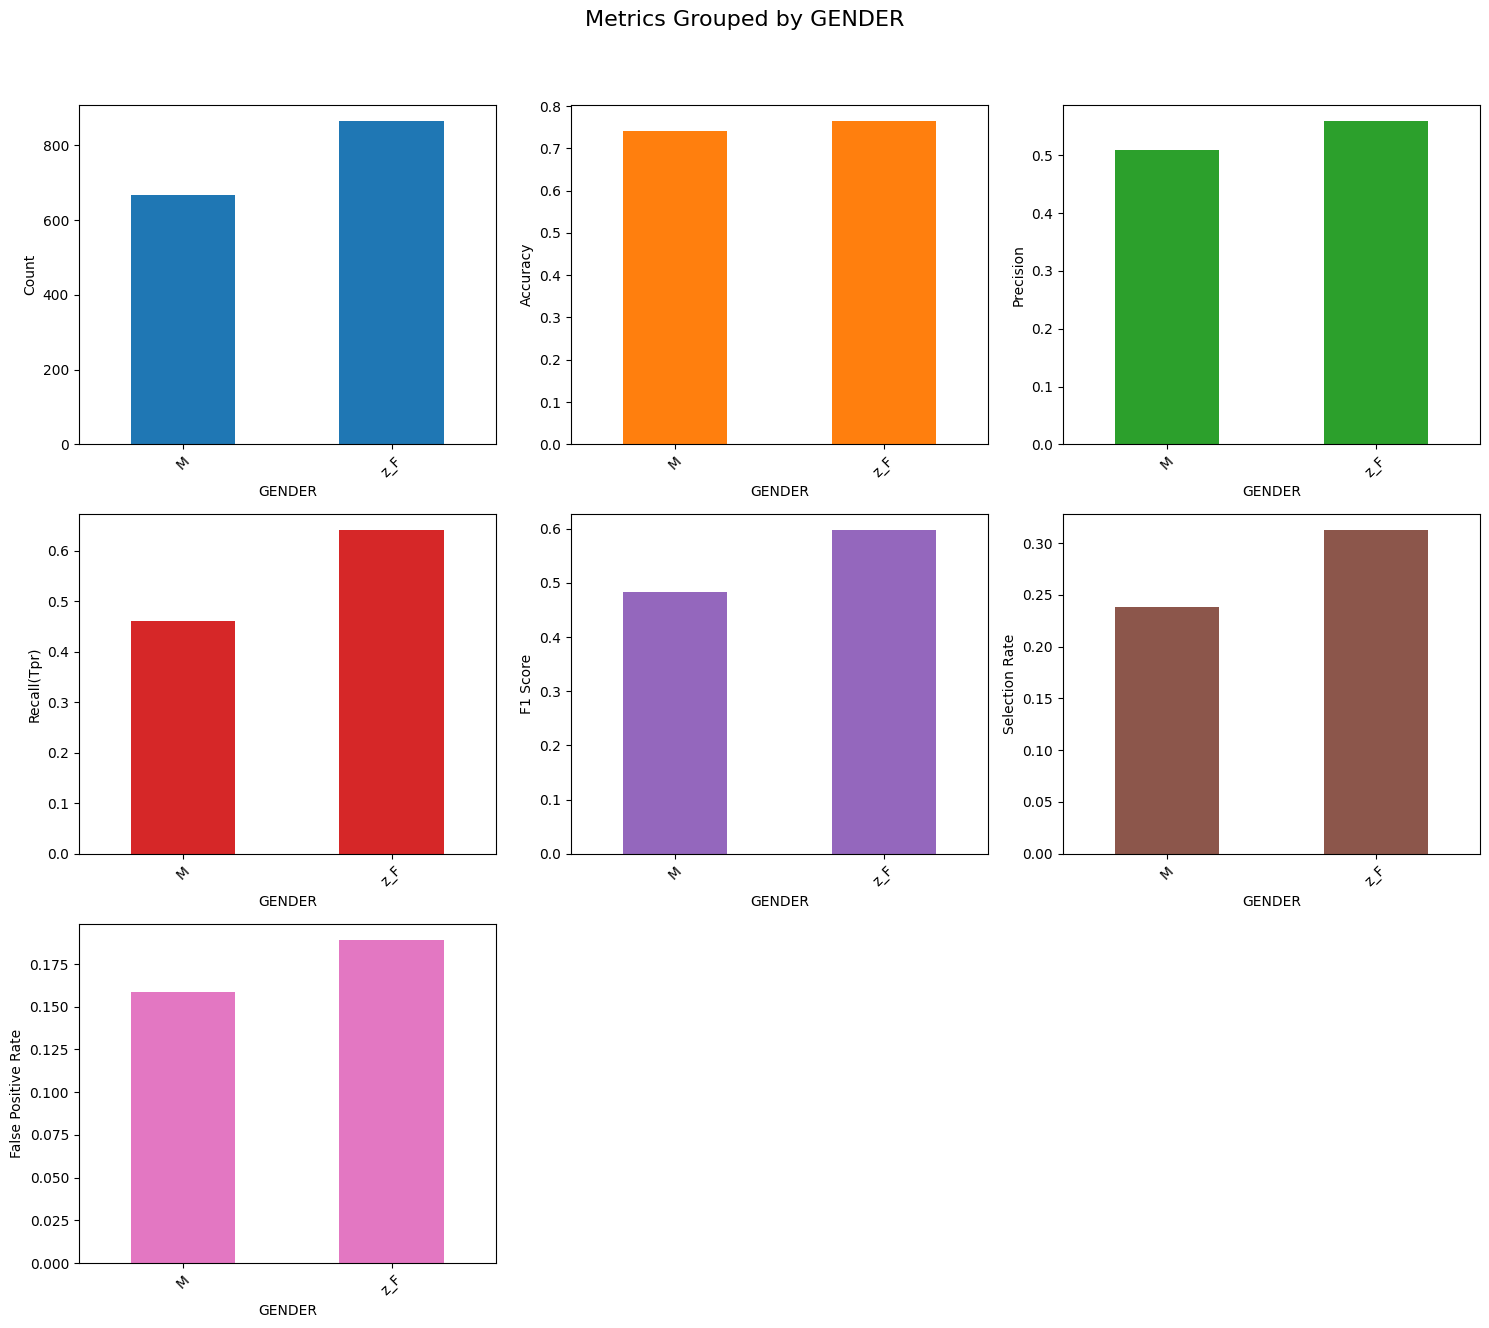

Plots generated.
----------------------------------------

--- Fairness Metrics grouped by: MSTATUS ---

Metrics By Group:
           count  accuracy  precision  recall(TPR)  f1_score  selection_rate  \
MSTATUS                                                                        
Yes     923.0000    0.7768     0.5213       0.4579    0.4876          0.2037   
z_No    609.0000    0.7192     0.5560       0.6768    0.6105          0.3957   

         false_positive_rate  
MSTATUS                       
Yes                   0.1269  
z_No                  0.2603  

Metric Differences (between max/min group):
count                 314.0000
accuracy                0.0576
precision               0.0347
recall(TPR)             0.2188
f1_score                0.1229
selection_rate          0.1920
false_positive_rate     0.1334
dtype: float64

Generating plots for metrics grouped by MSTATUS...


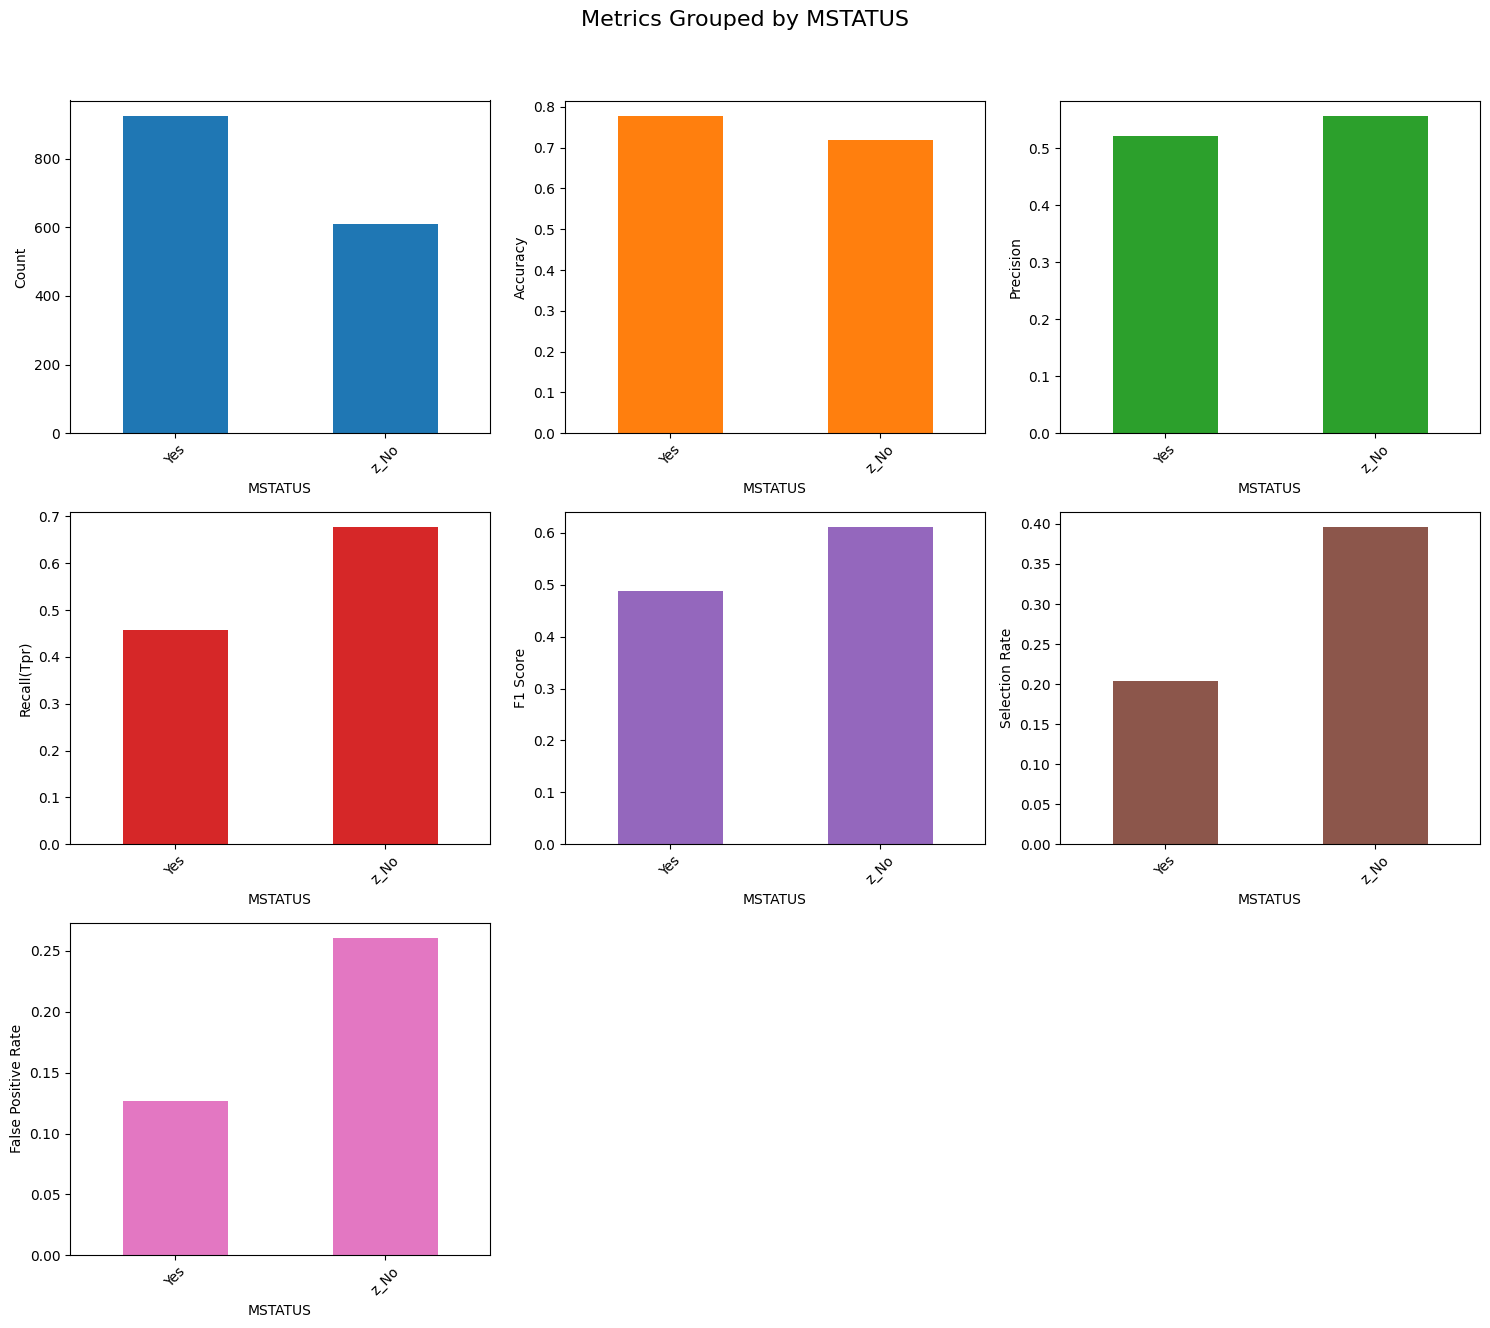

Plots generated.
----------------------------------------

--- Fairness Metrics grouped by: EDUCATION ---

Metrics By Group:
                 count  accuracy  precision  recall(TPR)  f1_score  \
EDUCATION                                                            
<High School  233.0000    0.6824     0.5714       0.4337    0.4932   
Bachelors     415.0000    0.8096     0.5000       0.5696    0.5325   
Masters       277.0000    0.7942     0.3571       0.3333    0.3448   
PhD           106.0000    0.7830     0.3529       0.3333    0.3429   
z_High School 501.0000    0.7126     0.5991       0.6952    0.6436   

               selection_rate  false_positive_rate  
EDUCATION                                           
<High School           0.2704               0.1800  
Bachelors              0.2169               0.1339  
Masters                0.1516               0.1164  
PhD                    0.1604               0.1250  
z_High School          0.4331               0.2771  

Metric Diffe

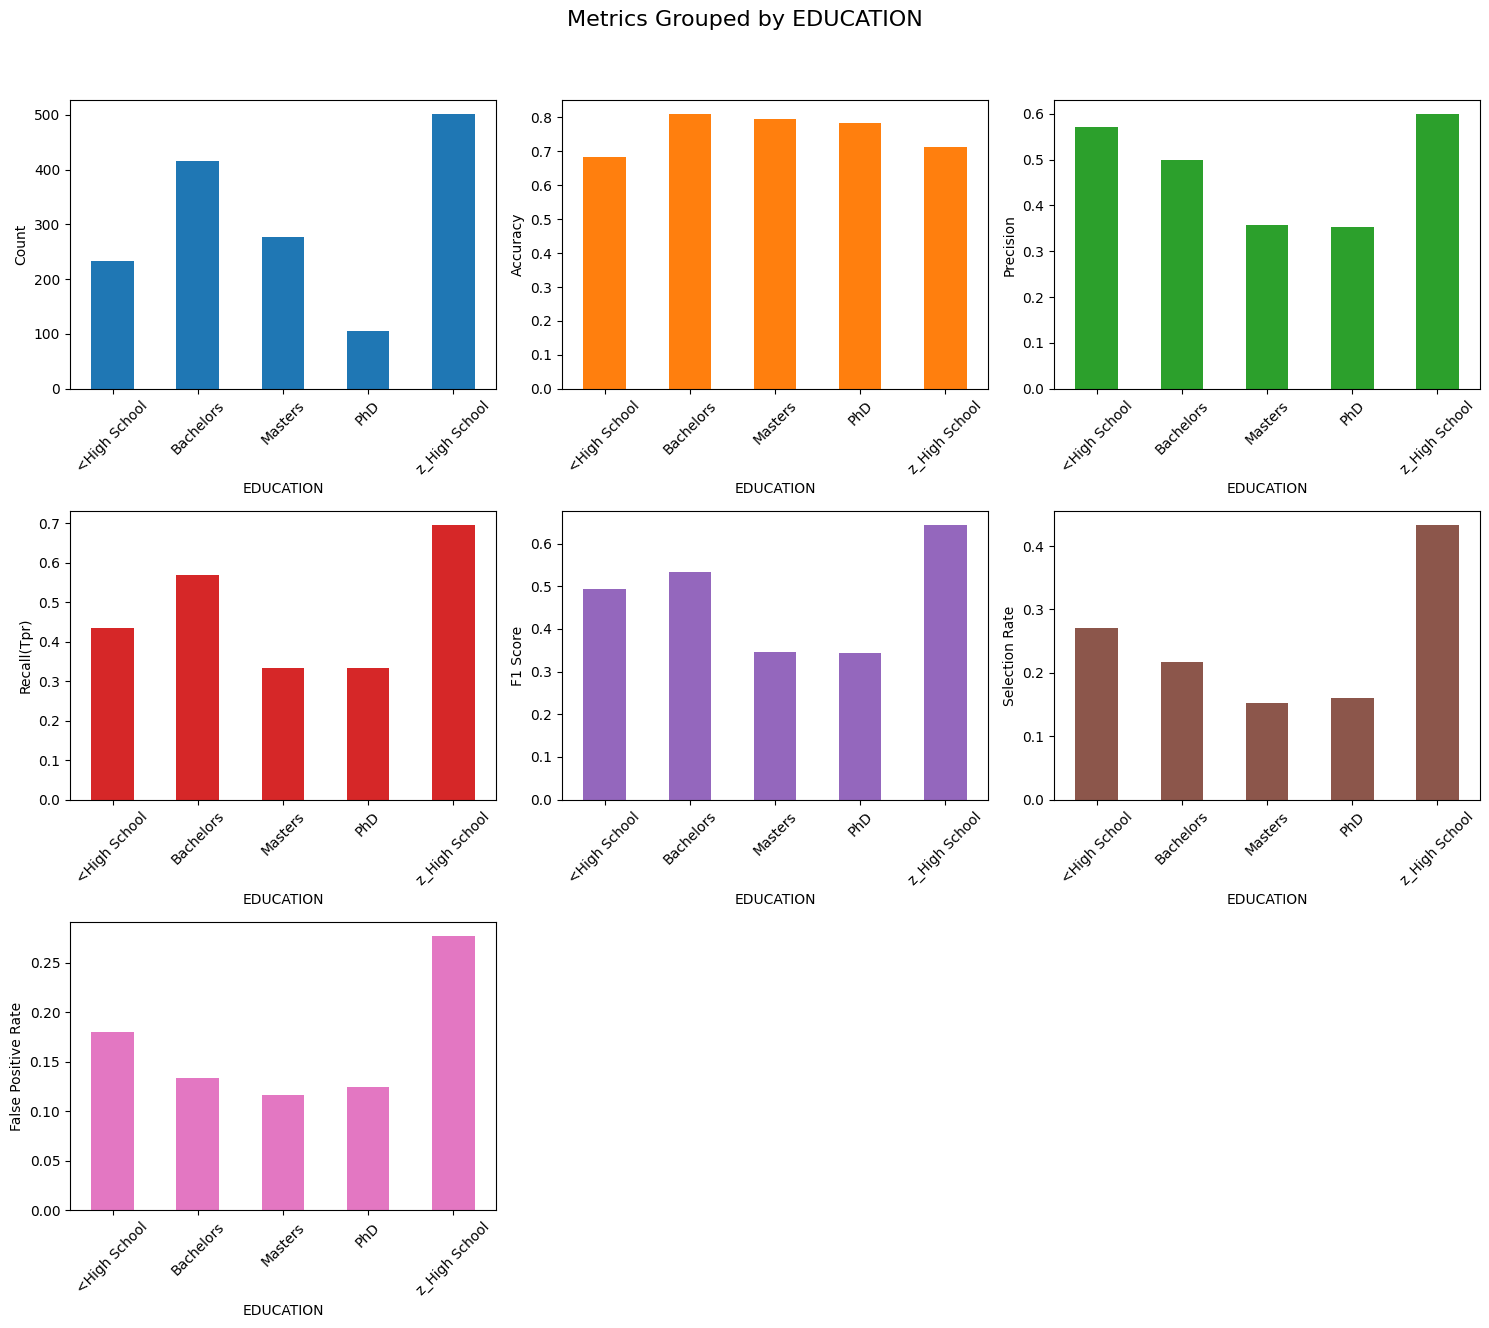

Plots generated.
----------------------------------------

--- Fairness Metrics grouped by: OCCUPATION ---

Metrics By Group:
                 count  accuracy  precision  recall(TPR)  f1_score  \
OCCUPATION                                                           
Clerical      255.0000    0.7412     0.6875       0.3929    0.5000   
Doctor         49.0000    0.8163     0.2500       0.1429    0.1818   
Home Maker    136.0000    0.6985     0.4146       0.5000    0.4533   
Lawyer        172.0000    0.8023     0.4857       0.5152    0.5000   
Manager       208.0000    0.8269     0.3182       0.2500    0.2800   
Professional  200.0000    0.7900     0.4250       0.4722    0.4474   
Student       135.0000    0.6444     0.5143       0.7200    0.6000   
z_Blue Collar 377.0000    0.7321     0.6154       0.7429    0.6731   

               selection_rate  false_positive_rate  
OCCUPATION                                          
Clerical               0.1882               0.0877  
Doctor        

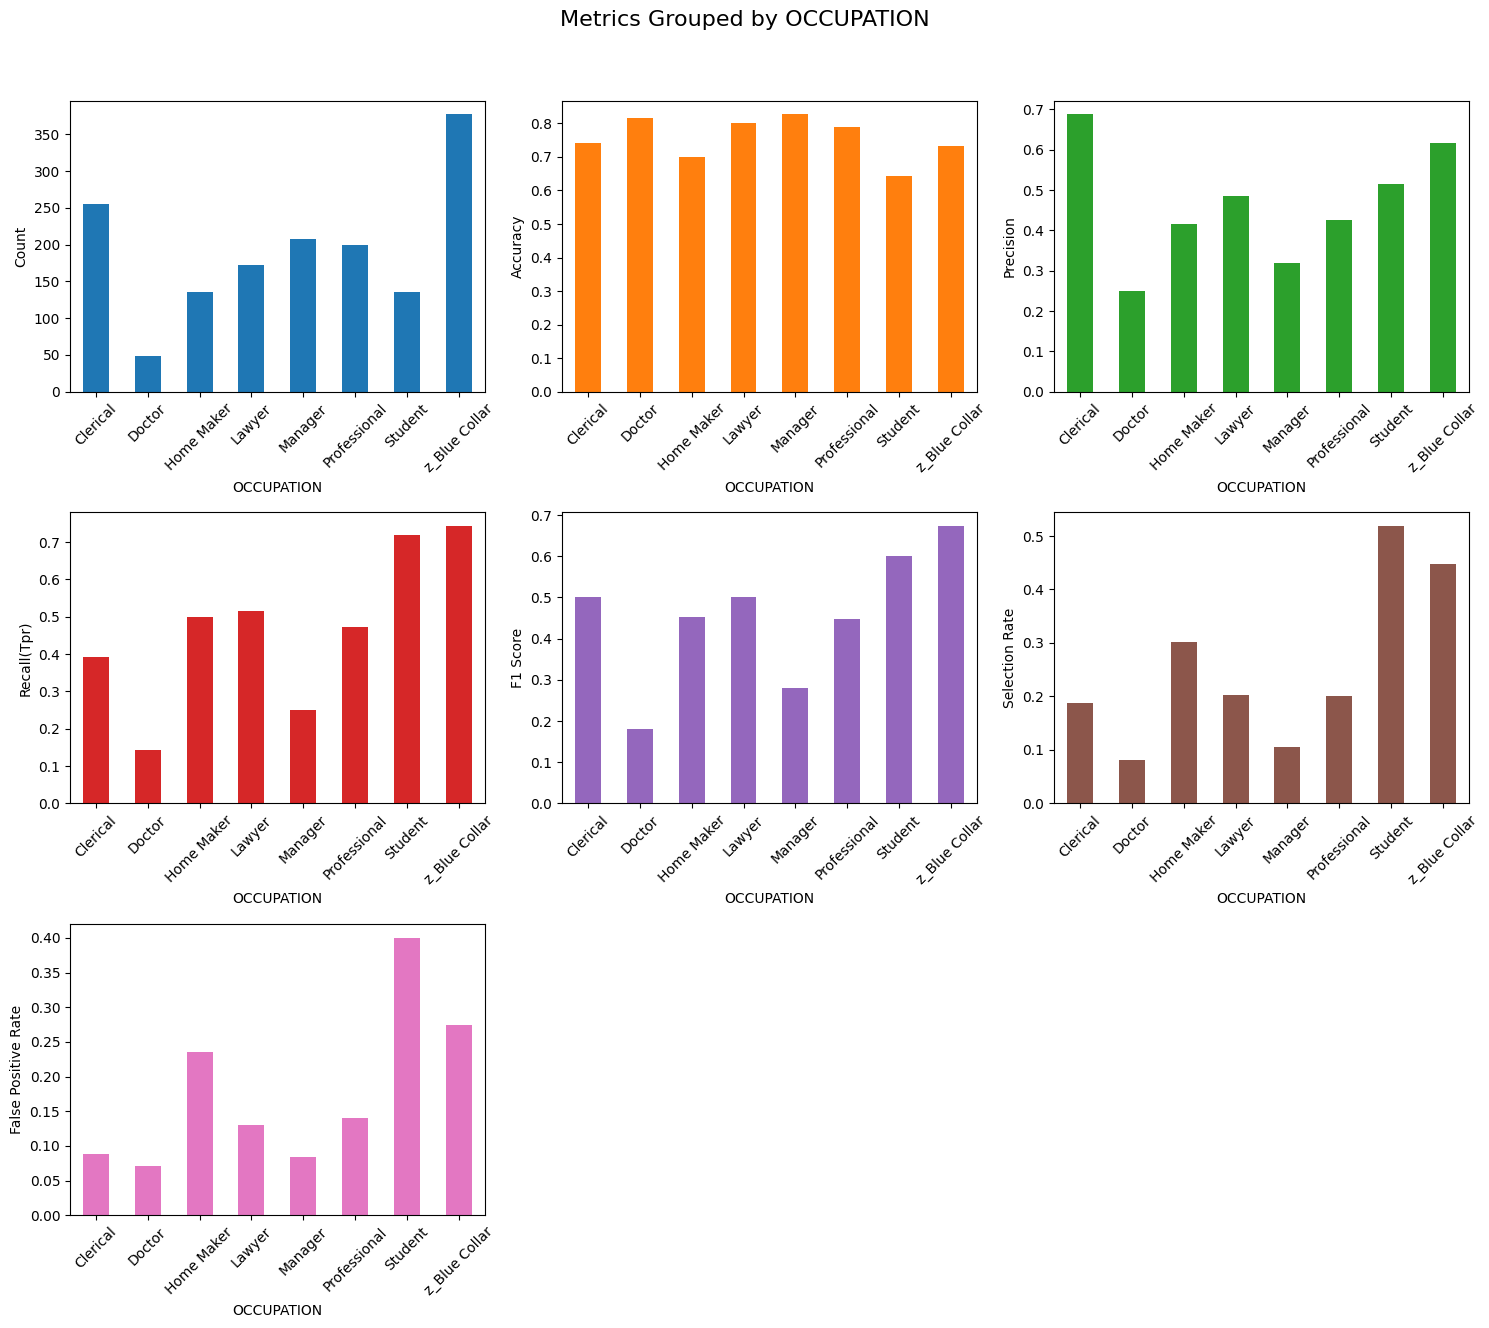

Plots generated.
----------------------------------------

--- Fairness Metrics grouped by: URBANICITY ---

Metrics By Group:
                           count  accuracy  precision  recall(TPR)  f1_score  \
URBANICITY                                                                     
Highly Urban/ Urban   1,193.0000    0.7108     0.5418       0.5974    0.5682   
z_Highly Rural/ Rural   339.0000    0.9056     0.5000       0.1562    0.2381   

                       selection_rate  false_positive_rate  
URBANICITY                                                  
Highly Urban/ Urban            0.3512               0.2362  
z_Highly Rural/ Rural          0.0295               0.0163  

Metric Differences (between max/min group):
count                 854.0000
accuracy                0.1948
precision               0.0418
recall(TPR)             0.4411
f1_score                0.3301
selection_rate          0.3217
false_positive_rate     0.2199
dtype: float64

Generating plots for metrics gr

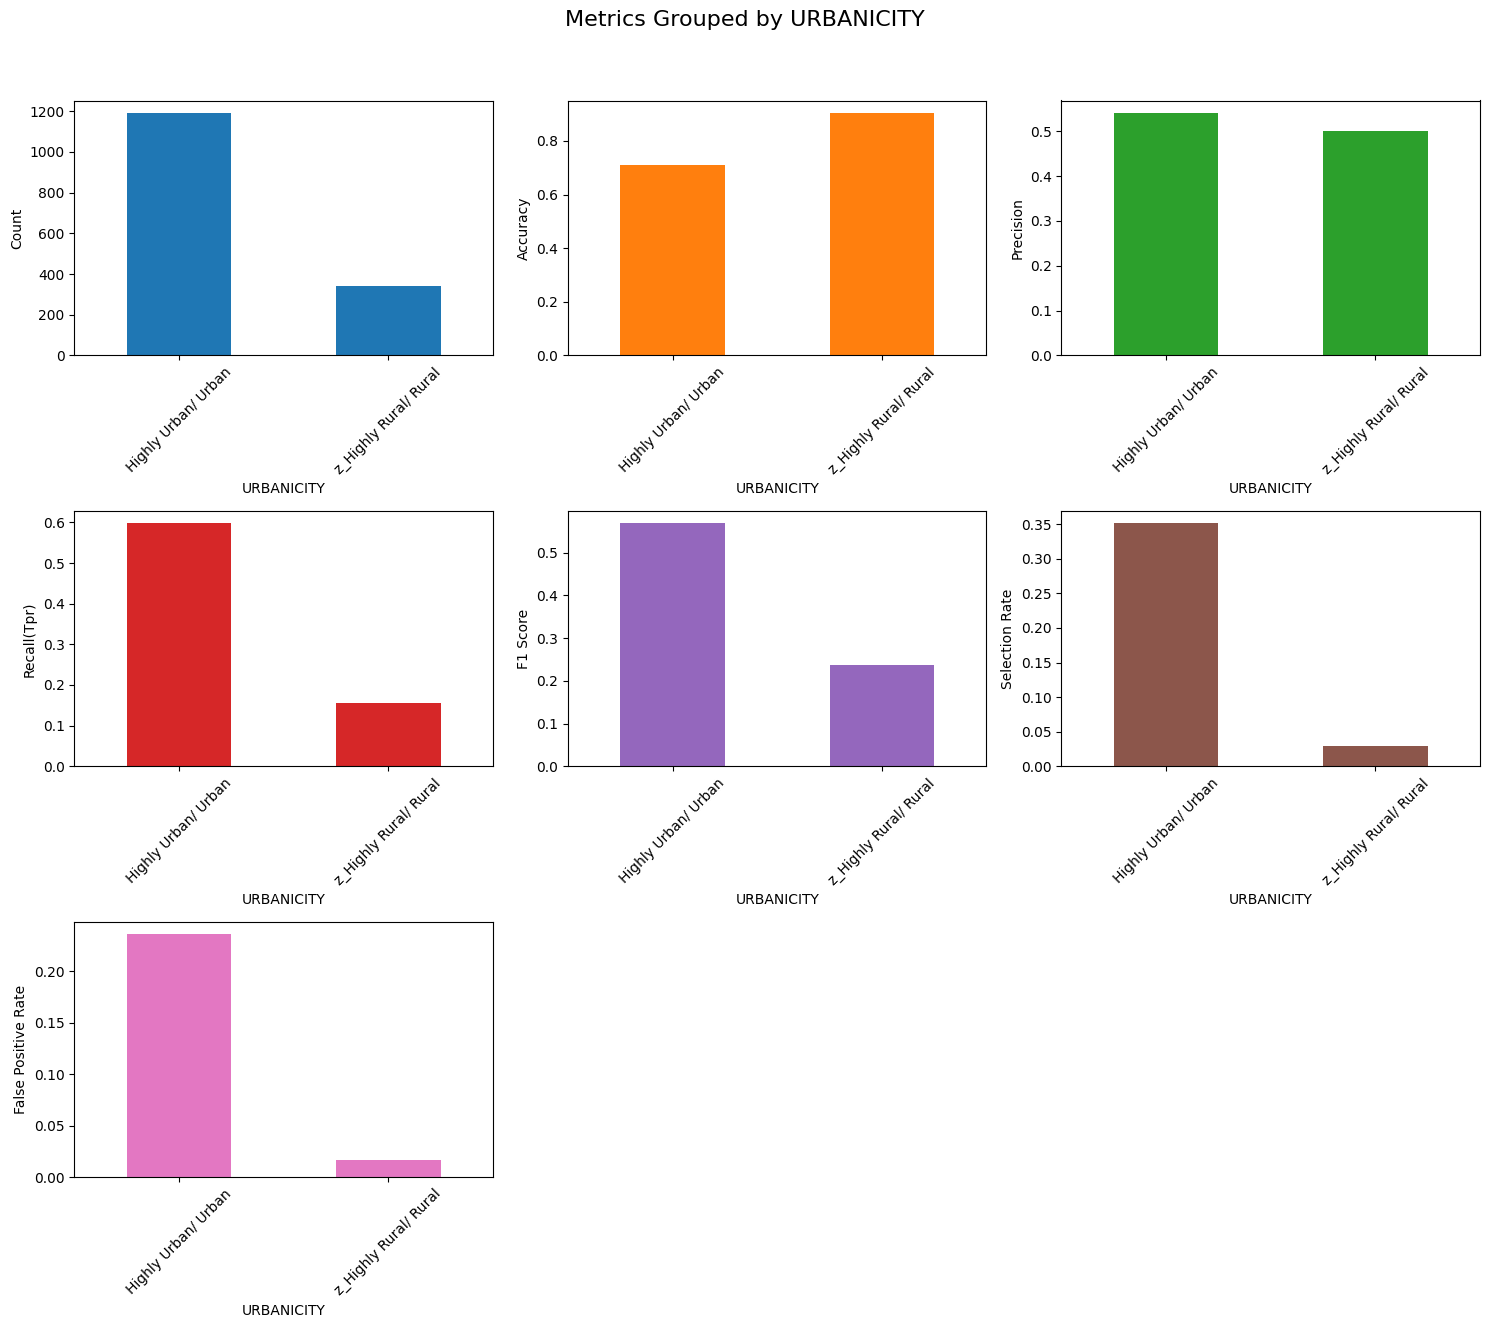

Plots generated.
----------------------------------------

--- Fairness Metrics grouped by: PARENT1 ---

Metrics By Group:
             count  accuracy  precision  recall(TPR)  f1_score  \
PARENT1                                                          
No      1,322.0000    0.7655     0.5248       0.4892    0.5064   
Yes       210.0000    0.6810     0.5794       0.8391    0.6854   

         selection_rate  false_positive_rate  
PARENT1                                       
No               0.2292               0.1444  
Yes              0.6000               0.4309  

Metric Differences (between max/min group):
count                 1,112.0000
accuracy                  0.0846
precision                 0.0546
recall(TPR)               0.3498
f1_score                  0.1791
selection_rate            0.3708
false_positive_rate       0.2865
dtype: float64

Generating plots for metrics grouped by PARENT1...


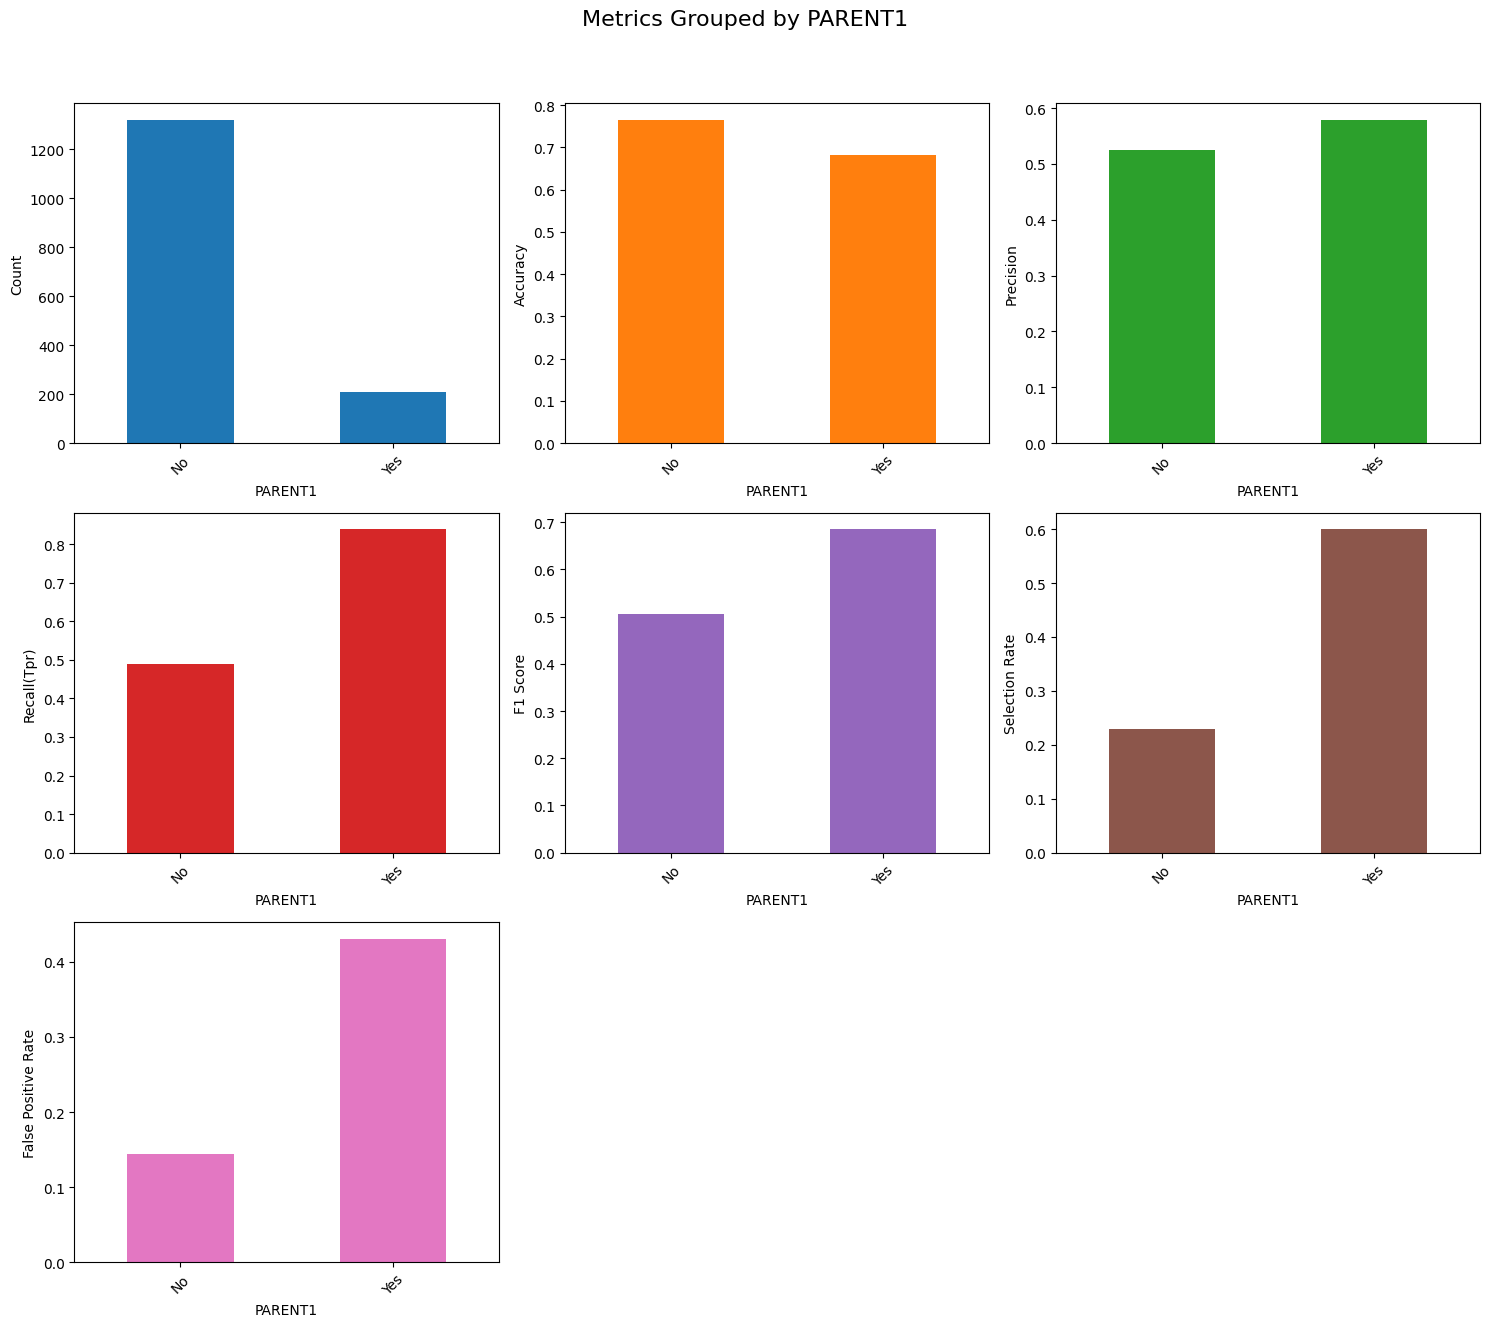

Plots generated.
----------------------------------------

--- Fairlearn Assessment Complete ---


In [56]:
# Logisstic Model and Fariness
print("\n--- Training Logistic Regression Model ---")
# Train on the SCALED and SMOTE'd training data
print("Training on SMOTE'd and Scaled training data...")
log_reg_model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
log_reg_model.fit(X_train_scaled, y_train_smote) # Use y_train_smote here
print("Logistic Regression model trained.")

# %% [markdown]
# ## 8. Get Model Predictions

# %%
print("\n--- Getting Predictions on Test Set ---")
y_pred_class_lr = log_reg_model.predict(X_test_scaled)
y_pred_proba_lr = log_reg_model.predict_proba(X_test_scaled)[:, 1] # Prob of class 1
print("Predictions obtained.")

# %% [markdown]
# ## 9. Fairlearn Assessment with Improved Plot Labels & Axis Fix

# %%
print("\n--- Starting Fairlearn Assessment ---")

# --- Align Original Sensitive Features with Test Set ---
sensitive_features_test_aligned = original_sensitive_features.loc[X_test.index]
print("Original sensitive features aligned with test set.")

# --- Define Metrics for Fairlearn ---
fairness_metrics = {
    'count': count,
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall(TPR)': true_positive_rate,
    'f1_score': f1_score,
    'selection_rate': selection_rate,
    'false_positive_rate': false_positive_rate,
}
print(f"Fairness metrics dictionary defined with keys: {list(fairness_metrics.keys())}")

# --- Loop Through Sensitive Attributes and Evaluate ---
for attribute in sensitive_attributes_list:
    if attribute not in sensitive_features_test_aligned.columns:
        print(f"\nWarning: Sensitive attribute '{attribute}' not found in aligned data. Skipping.")
        continue

    print(f"\n--- Fairness Metrics grouped by: {attribute} ---")

    # Prepare data for MetricFrame
    current_sensitive_feature = sensitive_features_test_aligned[attribute]
    valid_indices = current_sensitive_feature.dropna().index

    if valid_indices.empty:
        print(f"Skipping '{attribute}' due to all values being NaN after alignment.")
        continue

    current_y_test = y_test.loc[valid_indices]
    current_y_pred_class_s = pd.Series(y_pred_class_lr, index=X_test.index).loc[valid_indices]
    current_sensitive_feature = current_sensitive_feature.loc[valid_indices]

    if current_sensitive_feature.nunique() < 2 :
        print(f"Skipping '{attribute}' due to missing values or only one group remaining after alignment.")
        continue

    # Create MetricFrame
    grouped_on_attribute = MetricFrame(metrics=fairness_metrics,
                                       y_true=current_y_test,
                                       y_pred=current_y_pred_class_s,
                                       sensitive_features=current_sensitive_feature)

    # --- Print Text Results ---
    print("\nMetrics By Group:")
    try:
        with pd.option_context('display.float_format', '{:,.4f}'.format):
             print(grouped_on_attribute.by_group)
    except Exception as e:
        print(f"Could not display metrics by group for {attribute}: {e}")

    print(f"\nMetric Differences (between max/min group):")
    try:
        with pd.option_context('display.float_format', '{:,.4f}'.format):
            print(grouped_on_attribute.difference(method='between_groups'))
    except Exception as e:
        print(f"Could not display metric differences for {attribute}: {e}")

    # --- Generate Bar Plots with Y-axis Labels ---
    print(f"\nGenerating plots for metrics grouped by {attribute}...")
    try:
        num_metrics = len(fairness_metrics)
        ncols = 3
        nrows = (num_metrics + ncols - 1) // ncols
        layout = (nrows, ncols)
        figsize = (ncols * 5, nrows * 4.5) # Slightly increased height per row

        # Plot metrics values calculated 'by_group'
        ax_array = grouped_on_attribute.by_group.plot.bar(
            subplots=True,
            layout=layout,
            figsize=figsize,
            legend=False,
            rot=45,
            sharex=False # <<< ADDED THIS LINE to force labels on all subplots
        )

        # Flatten axes array for iteration
        ax_flat = ax_array.flatten() if isinstance(ax_array, np.ndarray) else [ax_array]

        # Add Y-axis labels based on subplot titles
        metric_names_in_order = grouped_on_attribute.by_group.columns
        for i, ax in enumerate(ax_flat):
             if i < len(metric_names_in_order):
                 metric_name = metric_names_in_order[i]
                 ax.set_ylabel(metric_name.replace("_", " ").title())
                 ax.set_title("") # Clear subplot title

                 # Ensure x-axis labels are visible after rotation
                 plt.setp(ax.get_xticklabels(), visible=True)


        plt.suptitle(f"Metrics Grouped by {attribute}", fontsize=16, y=1.01)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        # Sometimes an extra tight_layout call helps after adjustments
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()
        print("Plots generated.")
    except Exception as e:
        print(f"Could not generate plots for {attribute}: {e}")


    print("-" * 40)


print("\n--- Fairlearn Assessment Complete ---")

# Fairlearn Analysis Results for Logistic Regression Model

Based on the Fairlearn `MetricFrame` outputs from the provided PDF.

## GENDER

* **Recall (TPR):** The model correctly identifies ~64.0% of actual claims for the 'z_F' group, but only ~46.0% for the 'M' group, a difference of **18.0 percentage points**.
* **Selection Rate:** Claims are predicted for ~31.2% of the 'z_F' group versus ~23.8% for the 'M' group, a difference of **7.4 percentage points**.
* **False Positive Rate:** Non-claims are misidentified as claims at a rate of ~18.9% for 'z_F' versus ~15.9% for 'M', a difference of **3.0 percentage points**.

## MSTATUS (Marital Status)

* **Recall (TPR):** ~67.7% for 'z_No' versus ~45.8% for 'Yes', a difference of **21.9 percentage points**.
* **Selection Rate:** ~39.6% for 'z_No' versus ~20.4% for 'Yes', a difference of **19.2 percentage points**.
* **False Positive Rate:** ~26.0% for 'z_No' versus ~12.7% for 'Yes', a difference of **13.3 percentage points**.

## EDUCATION

* **Recall (TPR):** Varies greatly, from a low of ~33.3% ('Masters', 'PhD') up to ~69.5% ('z_High School'), a maximum difference of **36.2 percentage points**.
* **Selection Rate:** Ranges from ~15.2% ('Masters') to ~43.3% ('z_High School'), a maximum difference of **28.1 percentage points**.
* **False Positive Rate:** Ranges from ~11.6% ('Masters') to ~27.7% ('z_High School'), a maximum difference of **16.1 percentage points**.

## OCCUPATION

* **Recall (TPR):** Shows extreme variation, from ~14.3% ('Doctor') to ~74.3% ('z_Blue Collar'), a maximum difference of **60.0 percentage points**.
* **Selection Rate:** Ranges from ~8.2% ('Doctor') to ~51.9% ('Student'), a maximum difference of **43.7 percentage points**.
* **False Positive Rate:** Ranges from ~7.1% ('Doctor') to ~40.0% ('Student'), a maximum difference of **32.9 percentage points**.

## URBANICITY

* **Recall (TPR):** ~59.7% for 'Highly Urban/ Urban' versus ~15.6% for 'z_Highly Rural/ Rural', a difference of **44.1 percentage points**.
* **Selection Rate:** ~35.1% for 'Urban' versus ~3.0% for 'Rural', a difference of **32.1 percentage points**.
* **False Positive Rate:** ~23.6% for 'Urban' versus ~1.6% for 'Rural', a difference of **22.0 percentage points**.

## PARENT1 (Single Parent)

* **Recall (TPR):** ~83.9% for 'Yes' versus ~48.9% for 'No', a difference of **35.0 percentage points**.
* **Selection Rate:** ~60.0% for 'Yes' versus ~22.9% for 'No', a difference of **37.1 percentage points**.
* **False Positive Rate:** ~43.1% for 'Yes' versus ~14.4% for 'No', a difference of **28.7 percentage points**.

---

## Overall Conclusion (with Specific Values and Fairness Terms)

The Fairlearn analysis reveals substantial and consistent fairness disparities for the Logistic Regression model across all tested sensitive attributes (`GENDER`, `MSTATUS`, `EDUCATION`, `OCCUPATION`, `URBANICITY`, `PARENT1`).

Specifically, the differences in how the model treats various groups are numerically significant, indicating violations of standard fairness definitions:

* **Unequal Prediction Rates (Demographic Parity):** The likelihood of the model predicting a claim (**selection\_rate**) shows large gaps. The difference between the highest and lowest rates reaches approximately **43.7 percentage points** for `OCCUPATION` (between 'Doctor' and 'Student'), **37.1 points** for `PARENT1` ('No' vs. 'Yes'), **32.1 points** for `URBANICITY` ('Rural' vs. 'Urban'), and **28.1 points** for `EDUCATION` ('Masters' vs. 'z\_High School'). This indicates a failure to achieve **Demographic Parity**.
* **Unequal Ability to Identify Claims (Equal Opportunity):** The model's ability to correctly identify policyholders who actually file a claim (**recall(TPR)**) varies dramatically. The difference between the highest and lowest recall rates within an attribute reaches approximately **60.0 percentage points** for `OCCUPATION` ('Doctor' vs. 'z\_Blue Collar'), **44.1 points** for `URBANICITY` ('Rural' vs. 'Urban'), **36.2 points** for `EDUCATION` ('Masters'/'PhD' vs. 'z\_High School'), and **35.0 points** for `PARENT1` ('No' vs. 'Yes'). This indicates a significant failure to provide **Equal Opportunity**.
* **Unequal Error Rates (Equalized Odds):** The rate at which policyholders who did *not* file a claim are incorrectly predicted to have filed one (**false\_positive\_rate**) also differs substantially across groups, with maximum differences reaching approximately **32.9 percentage points** for `OCCUPATION` ('Doctor' vs. 'Student'), **28.7 points** for `PARENT1` ('No' vs. 'Yes'), and **22.0 points** for `URBANICITY` ('Rural' vs. 'Urban'). These FPR differences, combined with the large TPR differences noted above, indicate violations of **Equalized Odds**.

These specific, large numerical disparities across multiple fairness-critical metrics demonstrate that the model does not perform equitably according to these standard group fairness definitions. Its accuracy, likelihood of predicting a claim, and error patterns vary systematically depending on sensitive group membership, strongly suggesting fairness mitigation strategies should be considered.

## Gemini's Observation on Mitigating Disparity:
Yes, absolutely. Given that your Fairlearn analysis revealed significant disparities violating Equalized Odds (i.e., large differences in both True Positive Rates and False Positive Rates) across several sensitive attributes, applying a mitigation technique like ExponentiatedGradient with an EqualizedOdds constraint is a logical and appropriate next step.

The example in the screenshot uses ExponentiatedGradient, which is suitable because it can work with many standard classifiers (like your Logistic Regression) as a "black box" and attempts to find a model that minimizes classification errors subject to the fairness constraints you specify.

Here's how you can adapt that approach for your LogisticRegression model, using the pipeline we defined earlier (which includes scaling and SMOTE) as the base estimator.

Important: ExponentiatedGradient typically mitigates based on one sensitive attribute at a time. You'll need to choose which attribute you want to prioritize for mitigation first (e.g., OCCUPATION or URBANICITY showed large disparities). Let's use OCCUPATION as an example here.
##

# Mitigation

In [78]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay  # Add others if needed inside evaluate
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay # Ensure these are imported

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve # <<< Import calibration_curve here

# Occupation Mitgation

# Gender Mitgation


================= Mitigation: GENDER =================
Static definitions and helpers loaded for GENDER.
Reloading and preprocessing data for GENDER...
X_gender and y_gender defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for GENDER...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: GENDER (Mitigated) ---

Mitigated Metrics By Group:
        count  accuracy  precision  recall(TPR)  f1_score  selection_rate  \
GENDER                                                                      
M       667.0  0.770615   0.616162     0.346591  0.443636        0.148426   
z_F     865.0  0.781503   0.637427     0.461864  0.535627        0.197688   

        false_positive_rate  
GENDER                       
M                  0.077393  
z_F                0.098569  

Mitigated Metric Differences:
count                  198.000000
accuracy                 0.010888
precision                0.021265
recall(TPR)              0.115273
f1_score                 0.091

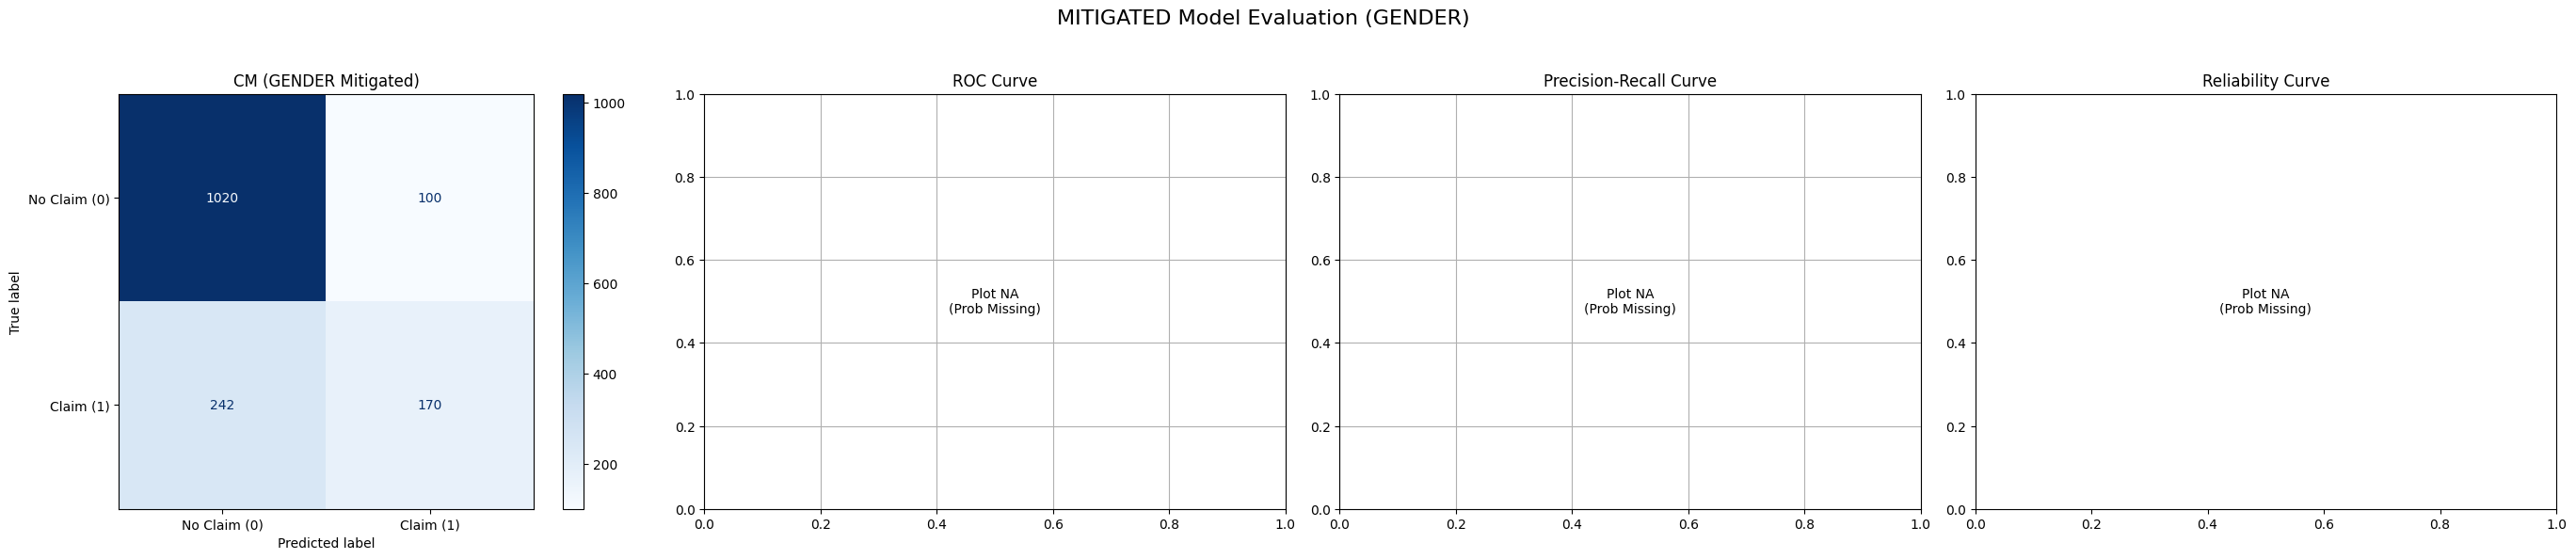

Plots generated.
--- Finished GENDER (Duration: 0.75 seconds) ---
------------------------------------------------------------


In [82]:
# Mitigate and Evaluate for GENDER (Self-Contained)

# %%
attribute_gender = 'GENDER'
print(f"\n================= Mitigation: {attribute_gender} =================")
loop_start_time_gender = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_GENDER = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_GENDER = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_GENDER = [ TARGET_VARIABLE_GENDER, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_GENDER = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_GENDER = EqualizedOdds()

def plot_reliability_curve_gender(y_true, y_prob, model_name, ax):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for GENDER.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for GENDER...")
try:
    car_insurance_data_gender = pd.read_csv(FILE_PATH_GENDER)
    currency_cols_gender = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_gender:
        if col in car_insurance_data_gender.columns: car_insurance_data_gender[col] = car_insurance_data_gender[col].replace('[\$,]', '', regex=True); car_insurance_data_gender[col] = pd.to_numeric(car_insurance_data_gender[col], errors='coerce')
    car_insurance_data_clean_gender = car_insurance_data_gender.dropna().copy()
    if attribute_gender not in car_insurance_data_clean_gender.columns: raise ValueError(f"Attribute '{attribute_gender}' not found.")
    original_sensitive_feature_series_gender = car_insurance_data_clean_gender[attribute_gender].copy()
    categorical_cols_all_gender = car_insurance_data_clean_gender.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_gender = pd.get_dummies(car_insurance_data_clean_gender, columns=categorical_cols_all_gender, drop_first=True)
    if TARGET_VARIABLE_GENDER not in car_insurance_encoded_gender.columns: raise ValueError("Target variable not found.")
    y_gender = car_insurance_encoded_gender[TARGET_VARIABLE_GENDER]
    columns_to_exclude_X_existing_gender = [col for col in COLUMNS_TO_EXCLUDE_X_GENDER if col in car_insurance_encoded_gender.columns]
    X_gender = car_insurance_encoded_gender.drop(columns=columns_to_exclude_X_existing_gender)
    print("X_gender and y_gender defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_gender, X_test_gender, y_train_gender, y_test_gender = train_test_split(X_gender, y_gender, test_size=0.20, random_state=42, stratify=y_gender)

# --- Align Sensitive Features ---
current_sensitive_train_gender = original_sensitive_feature_series_gender.loc[X_train_gender.index].dropna()
X_train_aligned_gender = X_train_gender.loc[current_sensitive_train_gender.index]; y_train_aligned_gender = y_train_gender.loc[current_sensitive_train_gender.index]
current_sensitive_test_gender = original_sensitive_feature_series_gender.loc[X_test_gender.index].dropna()
X_test_aligned_gender = X_test_gender.loc[current_sensitive_test_gender.index]; y_test_aligned_gender = y_test_gender.loc[current_sensitive_test_gender.index]
if X_train_aligned_gender.empty or X_test_aligned_gender.empty or current_sensitive_train_gender.nunique() < 2: print(f"Skipping '{attribute_gender}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_gender = StandardScaler(); X_train_scaled_gender = scaler_gender.fit_transform(X_train_aligned_gender); X_test_scaled_gender = scaler_gender.transform(X_test_aligned_gender); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_gender = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_gender}...")
mitigator_gender = ExponentiatedGradient(estimator=base_estimator_simple_gender, constraints=CONSTRAINT_GENDER)
try:
    mitigator_gender.fit(X_train_scaled_gender, y_train_aligned_gender, sensitive_features=current_sensitive_train_gender)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_gender = mitigator_gender.predict(X_test_scaled_gender)
    try: y_pred_proba_mitigated_gender = mitigator_gender.predict_proba(X_test_scaled_gender)[:, 1]
    except AttributeError: y_pred_proba_mitigated_gender = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_gender} (Mitigated) ---")
    grouped_on_gender_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_GENDER, y_true=y_test_aligned_gender, y_pred=y_pred_mitigated_gender, sensitive_features=current_sensitive_test_gender)
    print("\nMitigated Metrics By Group:"); print(grouped_on_gender_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_gender_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_gender, y_pred_mitigated_gender); f1_mitigated_minority = f1_score(y_test_aligned_gender, y_pred_mitigated_gender, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_gender, y_pred_mitigated_gender, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_gender} Mitigated)')
    if y_pred_proba_mitigated_gender is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_gender, y_pred_proba_mitigated_gender, ax=axes[1], name=f"{attribute_gender} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_gender, y_pred_proba_mitigated_gender, ax=axes[2], name=f"{attribute_gender} Mitigated"); plot_reliability_curve_gender(y_test_aligned_gender, y_pred_proba_mitigated_gender, f"{attribute_gender}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_gender})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_gender}: {e}")

loop_end_time_gender = time.time()
print(f"--- Finished {attribute_gender} (Duration: {loop_end_time_gender - loop_start_time_gender:.2f} seconds) ---")
print("-" * 60)

# MStatus Mitgation


================= Mitigation: MSTATUS =================
Static definitions and helpers loaded for MSTATUS.
Reloading and preprocessing data for MSTATUS...
X_mstatus and y_mstatus defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for MSTATUS...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: MSTATUS (Mitigated) ---

Mitigated Metrics By Group:
         count  accuracy  precision  recall(TPR)  f1_score  selection_rate  \
MSTATUS                                                                      
Yes      923.0  0.796316   0.584416     0.420561  0.489130        0.166847   
z_No     609.0  0.753695   0.684615     0.449495  0.542683        0.213465   

         false_positive_rate  
MSTATUS                       
Yes                 0.090268  
z_No                0.099757  

Mitigated Metric Differences:
count                  314.000000
accuracy                 0.042622
precision                0.100200
recall(TPR)              0.028934
f1_score       

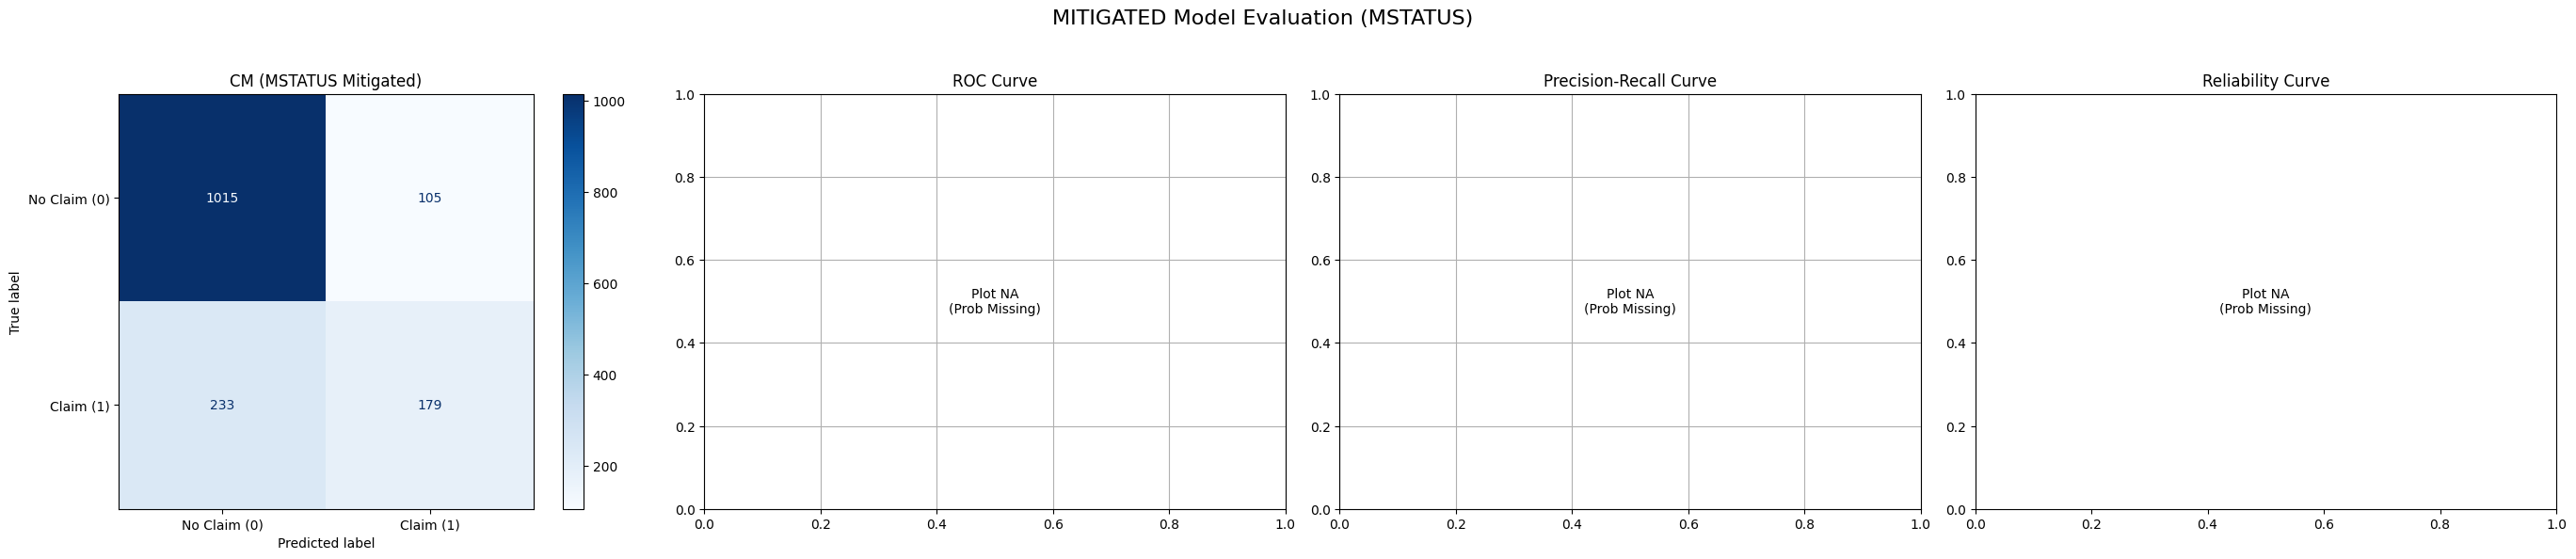

Plots generated.
--- Finished MSTATUS (Duration: 0.62 seconds) ---
------------------------------------------------------------


In [83]:
#  Mitigate and Evaluate for MSTATUS

attribute_mstatus = 'MSTATUS' # <-- Changed attribute
print(f"\n================= Mitigation: {attribute_mstatus} =================")
loop_start_time_mstatus = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_MSTATUS = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_MSTATUS = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_MSTATUS = [ TARGET_VARIABLE_MSTATUS, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_MSTATUS = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_MSTATUS = EqualizedOdds()

def plot_reliability_curve_mstatus(y_true, y_prob, model_name, ax):
    # (Same function definition as before)
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for MSTATUS.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for MSTATUS...")
try:
    car_insurance_data_mstatus = pd.read_csv(FILE_PATH_MSTATUS)
    currency_cols_mstatus = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_mstatus:
        if col in car_insurance_data_mstatus.columns: car_insurance_data_mstatus[col] = car_insurance_data_mstatus[col].replace('[\$,]', '', regex=True); car_insurance_data_mstatus[col] = pd.to_numeric(car_insurance_data_mstatus[col], errors='coerce')
    car_insurance_data_clean_mstatus = car_insurance_data_mstatus.dropna().copy()
    if attribute_mstatus not in car_insurance_data_clean_mstatus.columns: raise ValueError(f"Attribute '{attribute_mstatus}' not found.")
    original_sensitive_feature_series_mstatus = car_insurance_data_clean_mstatus[attribute_mstatus].copy()
    categorical_cols_all_mstatus = car_insurance_data_clean_mstatus.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_mstatus = pd.get_dummies(car_insurance_data_clean_mstatus, columns=categorical_cols_all_mstatus, drop_first=True)
    if TARGET_VARIABLE_MSTATUS not in car_insurance_encoded_mstatus.columns: raise ValueError("Target variable not found.")
    y_mstatus = car_insurance_encoded_mstatus[TARGET_VARIABLE_MSTATUS]
    columns_to_exclude_X_existing_mstatus = [col for col in COLUMNS_TO_EXCLUDE_X_MSTATUS if col in car_insurance_encoded_mstatus.columns]
    X_mstatus = car_insurance_encoded_mstatus.drop(columns=columns_to_exclude_X_existing_mstatus)
    print("X_mstatus and y_mstatus defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_mstatus, X_test_mstatus, y_train_mstatus, y_test_mstatus = train_test_split(X_mstatus, y_mstatus, test_size=0.20, random_state=42, stratify=y_mstatus)

# --- Align Sensitive Features ---
current_sensitive_train_mstatus = original_sensitive_feature_series_mstatus.loc[X_train_mstatus.index].dropna()
X_train_aligned_mstatus = X_train_mstatus.loc[current_sensitive_train_mstatus.index]; y_train_aligned_mstatus = y_train_mstatus.loc[current_sensitive_train_mstatus.index]
current_sensitive_test_mstatus = original_sensitive_feature_series_mstatus.loc[X_test_mstatus.index].dropna()
X_test_aligned_mstatus = X_test_mstatus.loc[current_sensitive_test_mstatus.index]; y_test_aligned_mstatus = y_test_mstatus.loc[current_sensitive_test_mstatus.index]
if X_train_aligned_mstatus.empty or X_test_aligned_mstatus.empty or current_sensitive_train_mstatus.nunique() < 2: print(f"Skipping '{attribute_mstatus}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_mstatus = StandardScaler(); X_train_scaled_mstatus = scaler_mstatus.fit_transform(X_train_aligned_mstatus); X_test_scaled_mstatus = scaler_mstatus.transform(X_test_aligned_mstatus); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_mstatus = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_mstatus}...")
mitigator_mstatus = ExponentiatedGradient(estimator=base_estimator_simple_mstatus, constraints=CONSTRAINT_MSTATUS)
try:
    mitigator_mstatus.fit(X_train_scaled_mstatus, y_train_aligned_mstatus, sensitive_features=current_sensitive_train_mstatus)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_mstatus = mitigator_mstatus.predict(X_test_scaled_mstatus)
    try: y_pred_proba_mitigated_mstatus = mitigator_mstatus.predict_proba(X_test_scaled_mstatus)[:, 1]
    except AttributeError: y_pred_proba_mitigated_mstatus = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_mstatus} (Mitigated) ---")
    grouped_on_mstatus_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_MSTATUS, y_true=y_test_aligned_mstatus, y_pred=y_pred_mitigated_mstatus, sensitive_features=current_sensitive_test_mstatus)
    print("\nMitigated Metrics By Group:"); print(grouped_on_mstatus_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_mstatus_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_mstatus, y_pred_mitigated_mstatus); f1_mitigated_minority = f1_score(y_test_aligned_mstatus, y_pred_mitigated_mstatus, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_mstatus, y_pred_mitigated_mstatus, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_mstatus} Mitigated)')
    if y_pred_proba_mitigated_mstatus is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_mstatus, y_pred_proba_mitigated_mstatus, ax=axes[1], name=f"{attribute_mstatus} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_mstatus, y_pred_proba_mitigated_mstatus, ax=axes[2], name=f"{attribute_mstatus} Mitigated"); plot_reliability_curve_mstatus(y_test_aligned_mstatus, y_pred_proba_mitigated_mstatus, f"{attribute_mstatus}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_mstatus})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_mstatus}: {e}")

loop_end_time_mstatus = time.time()
print(f"--- Finished {attribute_mstatus} (Duration: {loop_end_time_mstatus - loop_start_time_mstatus:.2f} seconds) ---")
print("-" * 60)

# Education Mitgation


================= Mitigation: EDUCATION =================
Static definitions and helpers loaded for EDUCATION.
Reloading and preprocessing data for EDUCATION...
X_education and y_education defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for EDUCATION...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: EDUCATION (Mitigated) ---

Mitigated Metrics By Group:
               count  accuracy  precision  recall(TPR)  f1_score  \
EDUCATION                                                          
<High School   233.0  0.699571   0.632653     0.373494  0.469697   
Bachelors      415.0  0.828916   0.566667     0.430380  0.489209   
Masters        277.0  0.826715   0.459459     0.377778  0.414634   
PhD            106.0  0.792453   0.333333     0.222222  0.266667   
z_High School  501.0  0.698603   0.680000     0.363636  0.473868   

               selection_rate  false_positive_rate  
EDUCATION                                           
<High School         0

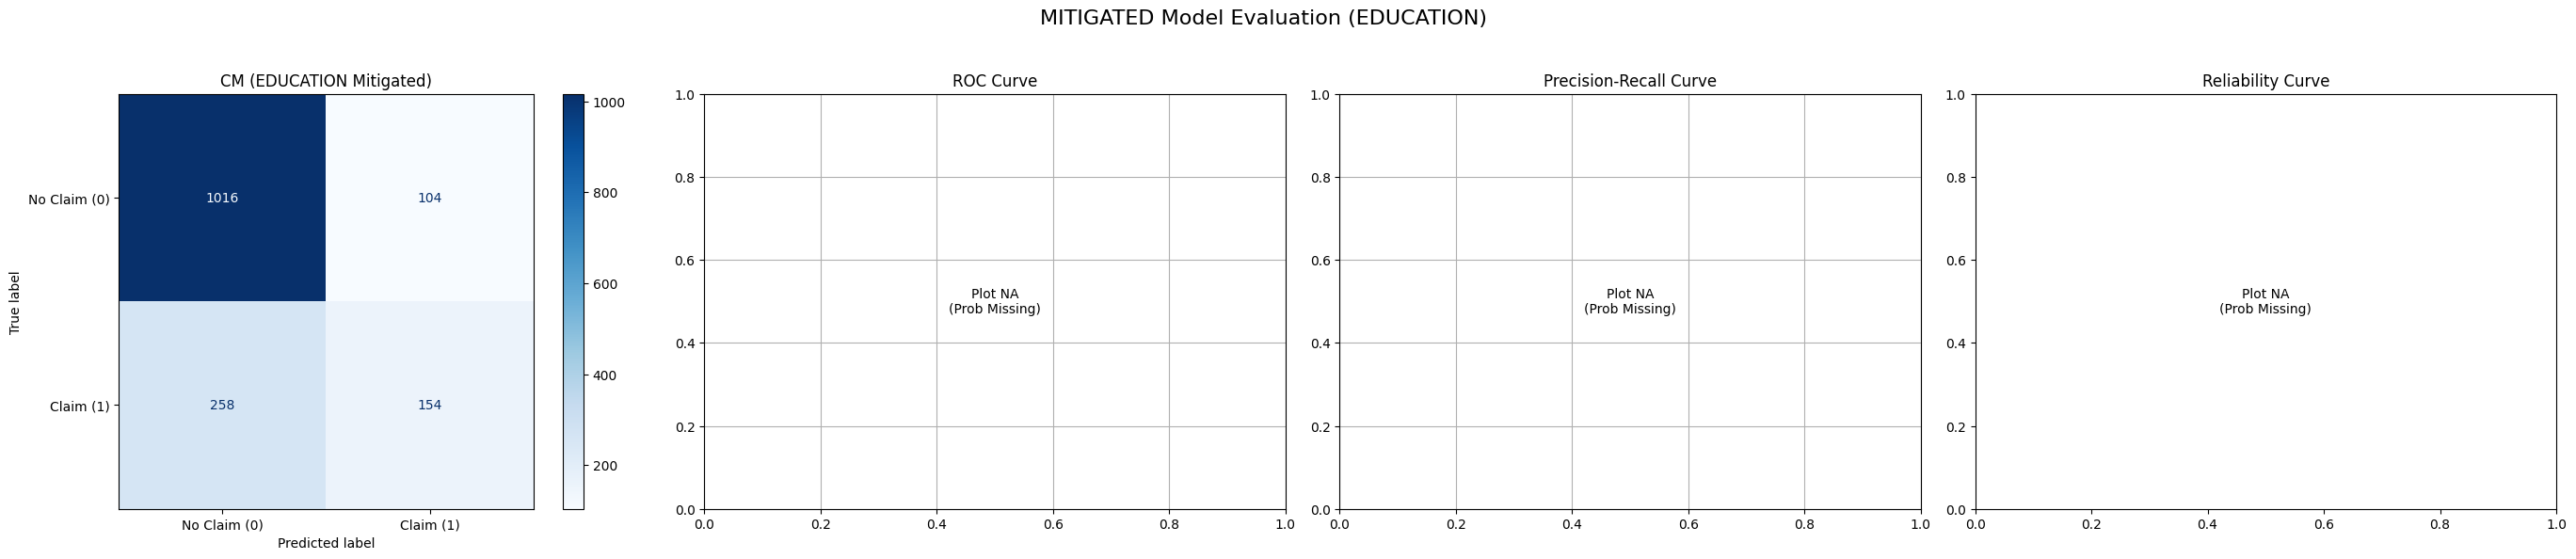

Plots generated.
--- Finished EDUCATION (Duration: 1.16 seconds) ---
------------------------------------------------------------


In [84]:
# Mitigate and Evaluate for EDUCATION

attribute_education = 'EDUCATION' # <-- Changed attribute
print(f"\n================= Mitigation: {attribute_education} =================")
loop_start_time_education = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_EDUCATION = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_EDUCATION = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_EDUCATION = [ TARGET_VARIABLE_EDUCATION, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_EDUCATION = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_EDUCATION = EqualizedOdds()
def plot_reliability_curve_education(y_true, y_prob, model_name, ax):
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for EDUCATION.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for EDUCATION...")
try:
    car_insurance_data_education = pd.read_csv(FILE_PATH_EDUCATION)
    currency_cols_education = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_education:
        if col in car_insurance_data_education.columns: car_insurance_data_education[col] = car_insurance_data_education[col].replace('[\$,]', '', regex=True); car_insurance_data_education[col] = pd.to_numeric(car_insurance_data_education[col], errors='coerce')
    car_insurance_data_clean_education = car_insurance_data_education.dropna().copy()
    if attribute_education not in car_insurance_data_clean_education.columns: raise ValueError(f"Attribute '{attribute_education}' not found.")
    original_sensitive_feature_series_education = car_insurance_data_clean_education[attribute_education].copy()
    categorical_cols_all_education = car_insurance_data_clean_education.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_education = pd.get_dummies(car_insurance_data_clean_education, columns=categorical_cols_all_education, drop_first=True)
    if TARGET_VARIABLE_EDUCATION not in car_insurance_encoded_education.columns: raise ValueError("Target variable not found.")
    y_education = car_insurance_encoded_education[TARGET_VARIABLE_EDUCATION]
    columns_to_exclude_X_existing_education = [col for col in COLUMNS_TO_EXCLUDE_X_EDUCATION if col in car_insurance_encoded_education.columns]
    X_education = car_insurance_encoded_education.drop(columns=columns_to_exclude_X_existing_education)
    print("X_education and y_education defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_education, X_test_education, y_train_education, y_test_education = train_test_split(X_education, y_education, test_size=0.20, random_state=42, stratify=y_education)

# --- Align Sensitive Features ---
current_sensitive_train_education = original_sensitive_feature_series_education.loc[X_train_education.index].dropna()
X_train_aligned_education = X_train_education.loc[current_sensitive_train_education.index]; y_train_aligned_education = y_train_education.loc[current_sensitive_train_education.index]
current_sensitive_test_education = original_sensitive_feature_series_education.loc[X_test_education.index].dropna()
X_test_aligned_education = X_test_education.loc[current_sensitive_test_education.index]; y_test_aligned_education = y_test_education.loc[current_sensitive_test_education.index]
if X_train_aligned_education.empty or X_test_aligned_education.empty or current_sensitive_train_education.nunique() < 2: print(f"Skipping '{attribute_education}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_education = StandardScaler(); X_train_scaled_education = scaler_education.fit_transform(X_train_aligned_education); X_test_scaled_education = scaler_education.transform(X_test_aligned_education); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_education = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_education}...")
mitigator_education = ExponentiatedGradient(estimator=base_estimator_simple_education, constraints=CONSTRAINT_EDUCATION)
try:
    mitigator_education.fit(X_train_scaled_education, y_train_aligned_education, sensitive_features=current_sensitive_train_education)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_education = mitigator_education.predict(X_test_scaled_education)
    try: y_pred_proba_mitigated_education = mitigator_education.predict_proba(X_test_scaled_education)[:, 1]
    except AttributeError: y_pred_proba_mitigated_education = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_education} (Mitigated) ---")
    grouped_on_education_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_EDUCATION, y_true=y_test_aligned_education, y_pred=y_pred_mitigated_education, sensitive_features=current_sensitive_test_education)
    print("\nMitigated Metrics By Group:"); print(grouped_on_education_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_education_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_education, y_pred_mitigated_education); f1_mitigated_minority = f1_score(y_test_aligned_education, y_pred_mitigated_education, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_education, y_pred_mitigated_education, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_education} Mitigated)')
    if y_pred_proba_mitigated_education is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_education, y_pred_proba_mitigated_education, ax=axes[1], name=f"{attribute_education} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_education, y_pred_proba_mitigated_education, ax=axes[2], name=f"{attribute_education} Mitigated"); plot_reliability_curve_education(y_test_aligned_education, y_pred_proba_mitigated_education, f"{attribute_education}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_education})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_education}: {e}")

loop_end_time_education = time.time()
print(f"--- Finished {attribute_education} (Duration: {loop_end_time_education - loop_start_time_education:.2f} seconds) ---")
print("-" * 60)

# Parent 1 Mitgation


================= Mitigation: PARENT1 =================
Static definitions and helpers loaded for PARENT1.
Reloading and preprocessing data for PARENT1...
X_parent1 and y_parent1 defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for PARENT1...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: PARENT1 (Mitigated) ---

Mitigated Metrics By Group:
          count  accuracy  precision  recall(TPR)  f1_score  selection_rate  \
PARENT1                                                                       
No       1322.0  0.788200   0.605634     0.396923  0.479554        0.161120   
Yes       210.0  0.704762   0.719298     0.471264  0.569444        0.271429   

         false_positive_rate  
PARENT1                       
No                  0.084253  
Yes                 0.130081  

Mitigated Metric Differences:
count                  1112.000000
accuracy                  0.083438
precision                 0.113664
recall(TPR)               0.074341
f1_scor

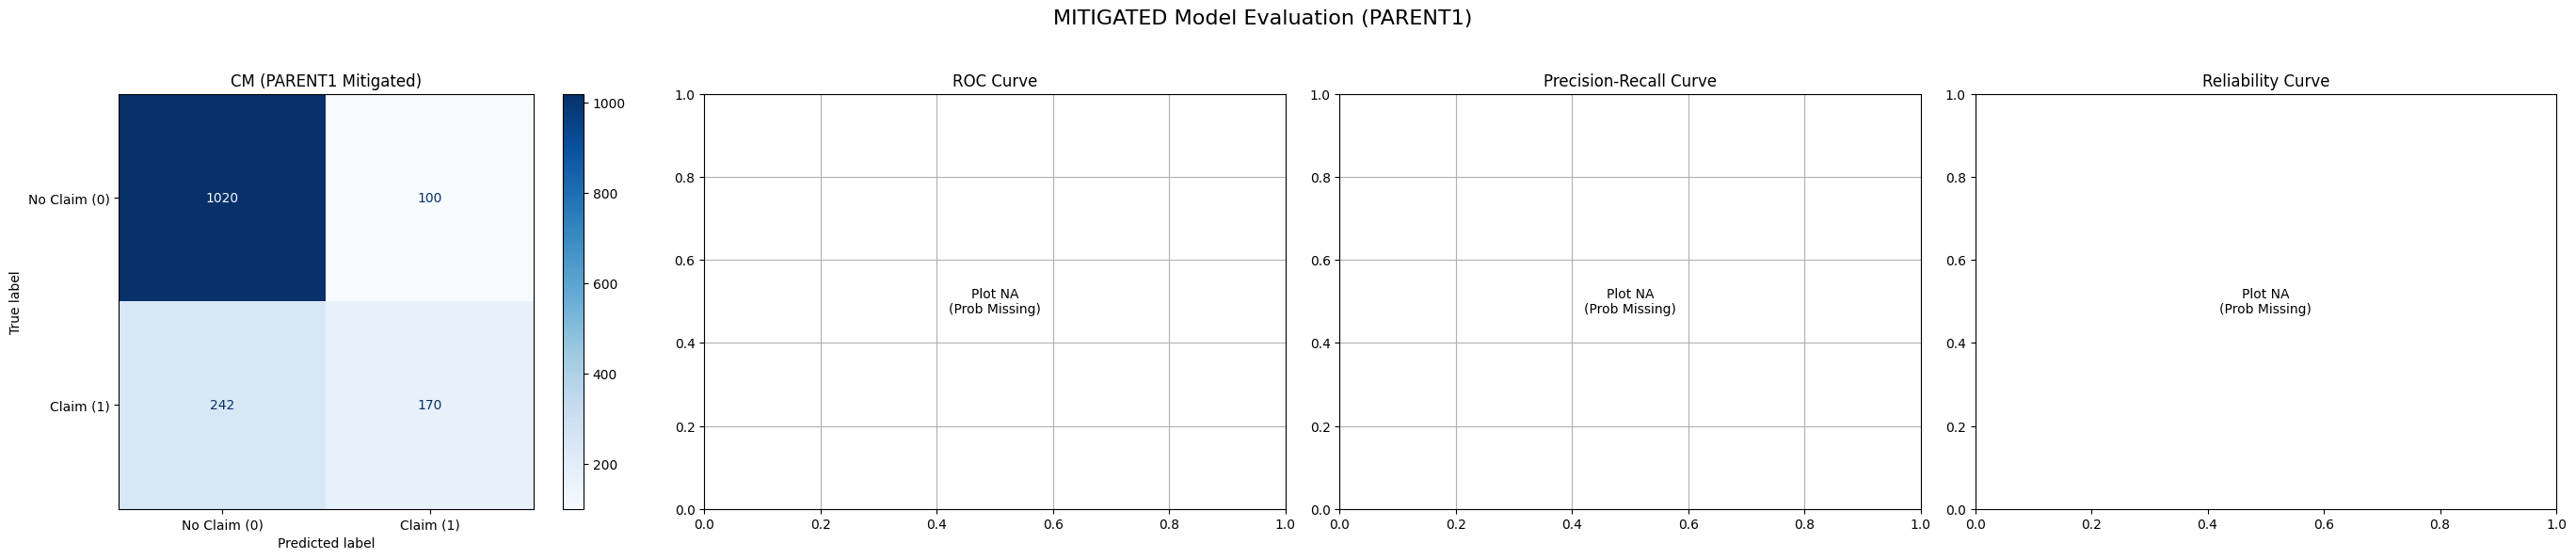

Plots generated.
--- Finished PARENT1 (Duration: 0.52 seconds) ---
------------------------------------------------------------


In [88]:
# Mitigate and Evaluate for PARENT1

# %%
attribute_parent1 = 'PARENT1' # <-- Change attribute
print(f"\n================= Mitigation: {attribute_parent1} =================")
loop_start_time_parent1 = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_PARENT1 = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_PARENT1 = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_PARENT1 = [ TARGET_VARIABLE_PARENT1, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_PARENT1 = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_PARENT1 = EqualizedOdds()
def plot_reliability_curve_parent1(y_true, y_prob, model_name, ax): # Function name changed
    # (Same function definition as before)
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for PARENT1.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for PARENT1...")
try:
    car_insurance_data_parent1 = pd.read_csv(FILE_PATH_PARENT1)
    currency_cols_parent1 = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_parent1:
        if col in car_insurance_data_parent1.columns: car_insurance_data_parent1[col] = car_insurance_data_parent1[col].replace('[\$,]', '', regex=True); car_insurance_data_parent1[col] = pd.to_numeric(car_insurance_data_parent1[col], errors='coerce')
    car_insurance_data_clean_parent1 = car_insurance_data_parent1.dropna().copy()
    if attribute_parent1 not in car_insurance_data_clean_parent1.columns: raise ValueError(f"Attribute '{attribute_parent1}' not found.")
    original_sensitive_feature_series_parent1 = car_insurance_data_clean_parent1[attribute_parent1].copy()
    categorical_cols_all_parent1 = car_insurance_data_clean_parent1.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_parent1 = pd.get_dummies(car_insurance_data_clean_parent1, columns=categorical_cols_all_parent1, drop_first=True)
    if TARGET_VARIABLE_PARENT1 not in car_insurance_encoded_parent1.columns: raise ValueError("Target variable not found.")
    y_parent1 = car_insurance_encoded_parent1[TARGET_VARIABLE_PARENT1]
    columns_to_exclude_X_existing_parent1 = [col for col in COLUMNS_TO_EXCLUDE_X_PARENT1 if col in car_insurance_encoded_parent1.columns]
    X_parent1 = car_insurance_encoded_parent1.drop(columns=columns_to_exclude_X_existing_parent1)
    print("X_parent1 and y_parent1 defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_parent1, X_test_parent1, y_train_parent1, y_test_parent1 = train_test_split(X_parent1, y_parent1, test_size=0.20, random_state=42, stratify=y_parent1)

# --- Align Sensitive Features ---
current_sensitive_train_parent1 = original_sensitive_feature_series_parent1.loc[X_train_parent1.index].dropna()
X_train_aligned_parent1 = X_train_parent1.loc[current_sensitive_train_parent1.index]; y_train_aligned_parent1 = y_train_parent1.loc[current_sensitive_train_parent1.index]
current_sensitive_test_parent1 = original_sensitive_feature_series_parent1.loc[X_test_parent1.index].dropna()
X_test_aligned_parent1 = X_test_parent1.loc[current_sensitive_test_parent1.index]; y_test_aligned_parent1 = y_test_parent1.loc[current_sensitive_test_parent1.index]
if X_train_aligned_parent1.empty or X_test_aligned_parent1.empty or current_sensitive_train_parent1.nunique() < 2: print(f"Skipping '{attribute_parent1}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_parent1 = StandardScaler(); X_train_scaled_parent1 = scaler_parent1.fit_transform(X_train_aligned_parent1); X_test_scaled_parent1 = scaler_parent1.transform(X_test_aligned_parent1); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_parent1 = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_parent1}...")
mitigator_parent1 = ExponentiatedGradient(estimator=base_estimator_simple_parent1, constraints=CONSTRAINT_PARENT1)
try:
    mitigator_parent1.fit(X_train_scaled_parent1, y_train_aligned_parent1, sensitive_features=current_sensitive_train_parent1)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_parent1 = mitigator_parent1.predict(X_test_scaled_parent1)
    try: y_pred_proba_mitigated_parent1 = mitigator_parent1.predict_proba(X_test_scaled_parent1)[:, 1]
    except AttributeError: y_pred_proba_mitigated_parent1 = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_parent1} (Mitigated) ---")
    grouped_on_parent1_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_PARENT1, y_true=y_test_aligned_parent1, y_pred=y_pred_mitigated_parent1, sensitive_features=current_sensitive_test_parent1)
    print("\nMitigated Metrics By Group:"); print(grouped_on_parent1_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_parent1_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_parent1, y_pred_mitigated_parent1); f1_mitigated_minority = f1_score(y_test_aligned_parent1, y_pred_mitigated_parent1, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_parent1, y_pred_mitigated_parent1, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_parent1} Mitigated)')
    if y_pred_proba_mitigated_parent1 is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_parent1, y_pred_proba_mitigated_parent1, ax=axes[1], name=f"{attribute_parent1} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_parent1, y_pred_proba_mitigated_parent1, ax=axes[2], name=f"{attribute_parent1} Mitigated"); plot_reliability_curve_parent1(y_test_aligned_parent1, y_pred_proba_mitigated_parent1, f"{attribute_parent1}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_parent1})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_parent1}: {e}")

loop_end_time_parent1 = time.time()
print(f"--- Finished {attribute_parent1} (Duration: {loop_end_time_parent1 - loop_start_time_parent1:.2f} seconds) ---")
print("-" * 60)

# Occupation Mitgation


================= Mitigation: OCCUPATION =================
Static definitions and helpers loaded for OCCUPATION.
Reloading and preprocessing data for OCCUPATION...
X_occupation and y_occupation defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for OCCUPATION...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: OCCUPATION (Mitigated) ---

Mitigated Metrics By Group:
               count  accuracy  precision  recall(TPR)  f1_score  \
OCCUPATION                                                         
Clerical       255.0  0.713725   0.677419     0.250000  0.365217   
Doctor          49.0  0.877551   0.571429     0.571429  0.571429   
Home Maker     136.0  0.742647   0.473684     0.264706  0.339623   
Lawyer         172.0  0.813953   0.523810     0.333333  0.407407   
Manager        208.0  0.812500   0.310345     0.321429  0.315789   
Professional   200.0  0.805000   0.400000     0.166667  0.235294   
Student        135.0  0.733333   0.750000     0.420000

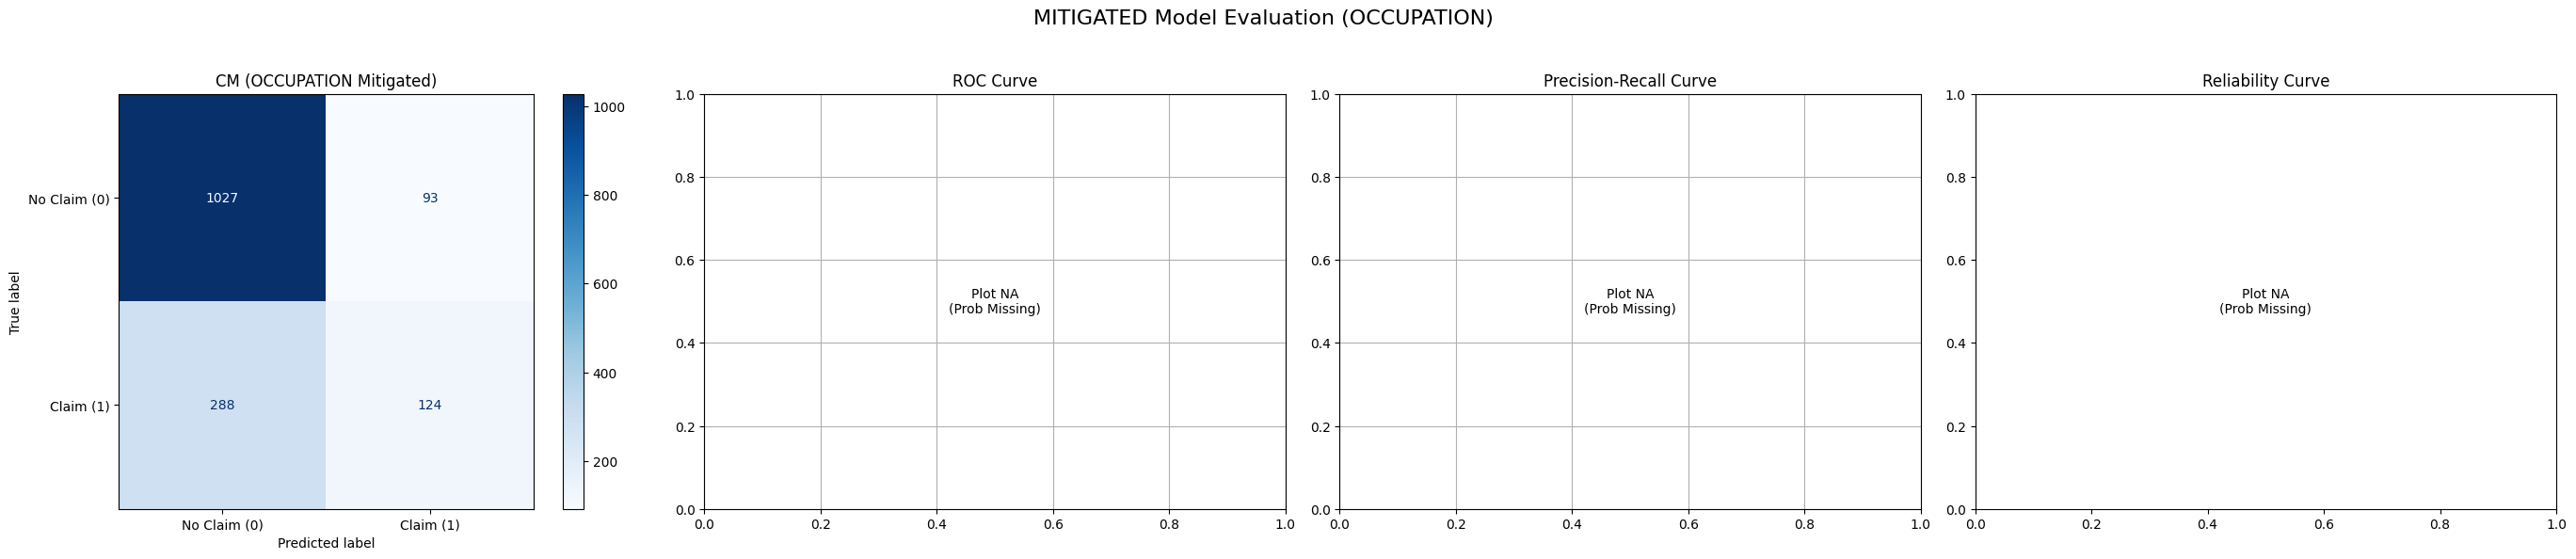

Plots generated.
--- Finished OCCUPATION (Duration: 1.35 seconds) ---
------------------------------------------------------------


In [86]:
# Mitigate and Evaluate for OCCUPATION

# %%
attribute_occupation = 'OCCUPATION' # <-- Change attribute
print(f"\n================= Mitigation: {attribute_occupation} =================")
loop_start_time_occupation = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_OCCUPATION = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_OCCUPATION = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_OCCUPATION = [ TARGET_VARIABLE_OCCUPATION, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_OCCUPATION = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_OCCUPATION = EqualizedOdds()
def plot_reliability_curve_occupation(y_true, y_prob, model_name, ax): # Function name changed for isolation
    # (Same function definition as before)
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for OCCUPATION.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for OCCUPATION...")
try:
    car_insurance_data_occupation = pd.read_csv(FILE_PATH_OCCUPATION)
    currency_cols_occupation = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_occupation:
        if col in car_insurance_data_occupation.columns: car_insurance_data_occupation[col] = car_insurance_data_occupation[col].replace('[\$,]', '', regex=True); car_insurance_data_occupation[col] = pd.to_numeric(car_insurance_data_occupation[col], errors='coerce')
    car_insurance_data_clean_occupation = car_insurance_data_occupation.dropna().copy()
    if attribute_occupation not in car_insurance_data_clean_occupation.columns: raise ValueError(f"Attribute '{attribute_occupation}' not found.")
    original_sensitive_feature_series_occupation = car_insurance_data_clean_occupation[attribute_occupation].copy()
    categorical_cols_all_occupation = car_insurance_data_clean_occupation.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_occupation = pd.get_dummies(car_insurance_data_clean_occupation, columns=categorical_cols_all_occupation, drop_first=True)
    if TARGET_VARIABLE_OCCUPATION not in car_insurance_encoded_occupation.columns: raise ValueError("Target variable not found.")
    y_occupation = car_insurance_encoded_occupation[TARGET_VARIABLE_OCCUPATION]
    columns_to_exclude_X_existing_occupation = [col for col in COLUMNS_TO_EXCLUDE_X_OCCUPATION if col in car_insurance_encoded_occupation.columns]
    X_occupation = car_insurance_encoded_occupation.drop(columns=columns_to_exclude_X_existing_occupation)
    print("X_occupation and y_occupation defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_occupation, X_test_occupation, y_train_occupation, y_test_occupation = train_test_split(X_occupation, y_occupation, test_size=0.20, random_state=42, stratify=y_occupation)

# --- Align Sensitive Features ---
current_sensitive_train_occupation = original_sensitive_feature_series_occupation.loc[X_train_occupation.index].dropna()
X_train_aligned_occupation = X_train_occupation.loc[current_sensitive_train_occupation.index]; y_train_aligned_occupation = y_train_occupation.loc[current_sensitive_train_occupation.index]
current_sensitive_test_occupation = original_sensitive_feature_series_occupation.loc[X_test_occupation.index].dropna()
X_test_aligned_occupation = X_test_occupation.loc[current_sensitive_test_occupation.index]; y_test_aligned_occupation = y_test_occupation.loc[current_sensitive_test_occupation.index]
if X_train_aligned_occupation.empty or X_test_aligned_occupation.empty or current_sensitive_train_occupation.nunique() < 2: print(f"Skipping '{attribute_occupation}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_occupation = StandardScaler(); X_train_scaled_occupation = scaler_occupation.fit_transform(X_train_aligned_occupation); X_test_scaled_occupation = scaler_occupation.transform(X_test_aligned_occupation); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_occupation = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_occupation}...")
mitigator_occupation = ExponentiatedGradient(estimator=base_estimator_simple_occupation, constraints=CONSTRAINT_OCCUPATION)
try:
    mitigator_occupation.fit(X_train_scaled_occupation, y_train_aligned_occupation, sensitive_features=current_sensitive_train_occupation)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_occupation = mitigator_occupation.predict(X_test_scaled_occupation)
    try: y_pred_proba_mitigated_occupation = mitigator_occupation.predict_proba(X_test_scaled_occupation)[:, 1]
    except AttributeError: y_pred_proba_mitigated_occupation = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_occupation} (Mitigated) ---")
    grouped_on_occupation_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_OCCUPATION, y_true=y_test_aligned_occupation, y_pred=y_pred_mitigated_occupation, sensitive_features=current_sensitive_test_occupation)
    print("\nMitigated Metrics By Group:"); print(grouped_on_occupation_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_occupation_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_occupation, y_pred_mitigated_occupation); f1_mitigated_minority = f1_score(y_test_aligned_occupation, y_pred_mitigated_occupation, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_occupation, y_pred_mitigated_occupation, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_occupation} Mitigated)')
    if y_pred_proba_mitigated_occupation is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_occupation, y_pred_proba_mitigated_occupation, ax=axes[1], name=f"{attribute_occupation} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_occupation, y_pred_proba_mitigated_occupation, ax=axes[2], name=f"{attribute_occupation} Mitigated"); plot_reliability_curve_occupation(y_test_aligned_occupation, y_pred_proba_mitigated_occupation, f"{attribute_occupation}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_occupation})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_occupation}: {e}")

loop_end_time_occupation = time.time()
print(f"--- Finished {attribute_occupation} (Duration: {loop_end_time_occupation - loop_start_time_occupation:.2f} seconds) ---")
print("-" * 60)

# Urbanacity Mitigation


================= Mitigation: URBANICITY =================
Static definitions and helpers loaded for URBANICITY.
Reloading and preprocessing data for URBANICITY...
X_urbanicity and y_urbanicity defined.
Data aligned.
Data scaled.
Fitting ExponentiatedGradient for URBANICITY...
Fitting complete.
Predictions obtained.

--- Fairlearn Assessment: URBANICITY (Mitigated) ---

Mitigated Metrics By Group:
                        count  accuracy  precision  recall(TPR)  f1_score  \
URBANICITY                                                                  
Highly Urban/ Urban    1193.0  0.730930   0.666667     0.310526  0.423698   
z_Highly Rural/ Rural   339.0  0.879056   0.344828     0.312500  0.327869   

                       selection_rate  false_positive_rate  
URBANICITY                                                  
Highly Urban/ Urban          0.148365             0.072571  
z_Highly Rural/ Rural        0.085546             0.061889  

Mitigated Metric Differences:
count         

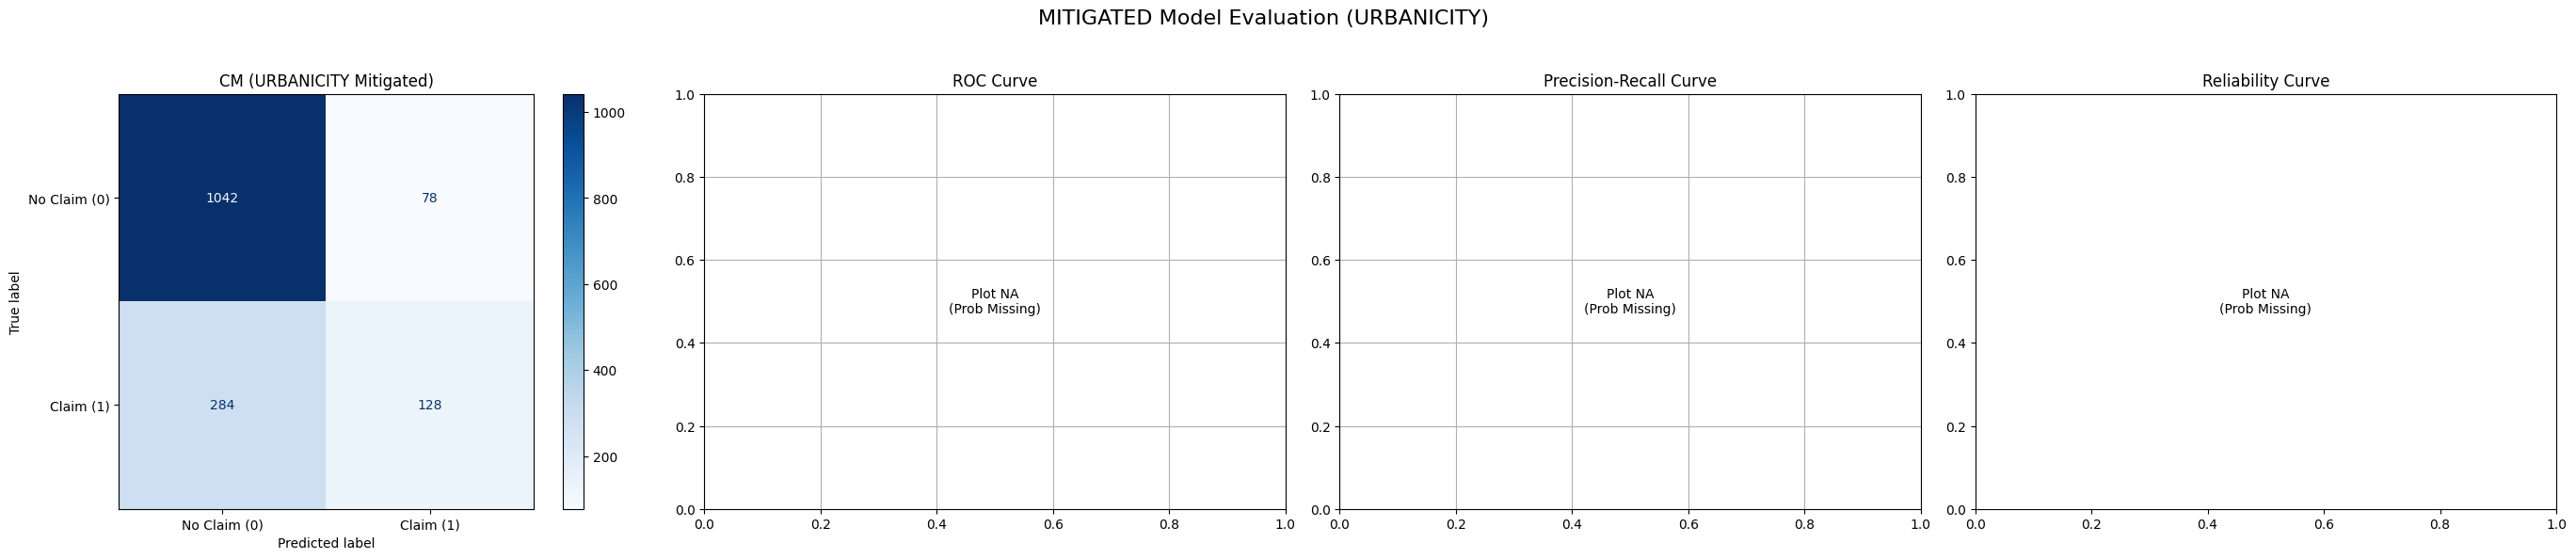

Plots generated.
--- Finished URBANICITY (Duration: 0.83 seconds) ---
------------------------------------------------------------


In [87]:
# Mitigate and Evaluate for URBANICITY

# %%
attribute_urbanicity = 'URBANICITY' # <-- Change attribute
print(f"\n================= Mitigation: {attribute_urbanicity} =================")
loop_start_time_urbanicity = time.time()

# --- Static Definitions & Helpers (Duplicated for Isolation) ---
FILE_PATH_URBANICITY = "/Users/goyolozano/Desktop/Mini 4/Ethics/Update 3/car_insurance_claim.csv"
TARGET_VARIABLE_URBANICITY = 'CLAIM_FLAG'
COLUMNS_TO_EXCLUDE_X_URBANICITY = [ TARGET_VARIABLE_URBANICITY, 'CLM_AMT', 'ID' ]
FAIRNESS_METRICS_URBANICITY = {
    'count': count, 'accuracy': accuracy_score, 'precision': precision_score,
    'recall(TPR)': true_positive_rate, 'f1_score': f1_score,
    'selection_rate': selection_rate, 'false_positive_rate': false_positive_rate,
}
CONSTRAINT_URBANICITY = EqualizedOdds()
def plot_reliability_curve_urbanicity(y_true, y_prob, model_name, ax): # Function name changed
    # (Same function definition as before)
    try:
        prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy='uniform')
        ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated', color='grey')
        ax.plot(prob_pred, prob_true, marker='.', label=f'{model_name} (Mitigated)')
        ax.set_xlabel("Mean Predicted Probability (bin)"); ax.set_ylabel("Fraction of Positives (bin)")
        ax.set_title("Reliability Curve"); ax.legend(); ax.grid(True)
    except ValueError: ax.text(0.5, 0.5, 'Reliability plot NA \n(predict_proba unavailable)', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
    except Exception as e: ax.text(0.5, 0.5, f'Reliability plot Error:\n{e}', ha='center', va='center', transform=ax.transAxes); ax.set_title("Reliability Curve"); ax.grid(True)
print("Static definitions and helpers loaded for URBANICITY.")

# --- Reload and Preprocess Data ---
print("Reloading and preprocessing data for URBANICITY...")
try:
    car_insurance_data_urbanicity = pd.read_csv(FILE_PATH_URBANICITY)
    currency_cols_urbanicity = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM', 'CLM_AMT']
    for col in currency_cols_urbanicity:
        if col in car_insurance_data_urbanicity.columns: car_insurance_data_urbanicity[col] = car_insurance_data_urbanicity[col].replace('[\$,]', '', regex=True); car_insurance_data_urbanicity[col] = pd.to_numeric(car_insurance_data_urbanicity[col], errors='coerce')
    car_insurance_data_clean_urbanicity = car_insurance_data_urbanicity.dropna().copy()
    if attribute_urbanicity not in car_insurance_data_clean_urbanicity.columns: raise ValueError(f"Attribute '{attribute_urbanicity}' not found.")
    original_sensitive_feature_series_urbanicity = car_insurance_data_clean_urbanicity[attribute_urbanicity].copy()
    categorical_cols_all_urbanicity = car_insurance_data_clean_urbanicity.select_dtypes(include=['object']).columns.tolist()
    car_insurance_encoded_urbanicity = pd.get_dummies(car_insurance_data_clean_urbanicity, columns=categorical_cols_all_urbanicity, drop_first=True)
    if TARGET_VARIABLE_URBANICITY not in car_insurance_encoded_urbanicity.columns: raise ValueError("Target variable not found.")
    y_urbanicity = car_insurance_encoded_urbanicity[TARGET_VARIABLE_URBANICITY]
    columns_to_exclude_X_existing_urbanicity = [col for col in COLUMNS_TO_EXCLUDE_X_URBANICITY if col in car_insurance_encoded_urbanicity.columns]
    X_urbanicity = car_insurance_encoded_urbanicity.drop(columns=columns_to_exclude_X_existing_urbanicity)
    print("X_urbanicity and y_urbanicity defined.")
except Exception as e: print(f"ERROR during data loading/preprocessing: {e}"); exit()

# --- Split Data ---
X_train_urbanicity, X_test_urbanicity, y_train_urbanicity, y_test_urbanicity = train_test_split(X_urbanicity, y_urbanicity, test_size=0.20, random_state=42, stratify=y_urbanicity)

# --- Align Sensitive Features ---
current_sensitive_train_urbanicity = original_sensitive_feature_series_urbanicity.loc[X_train_urbanicity.index].dropna()
X_train_aligned_urbanicity = X_train_urbanicity.loc[current_sensitive_train_urbanicity.index]; y_train_aligned_urbanicity = y_train_urbanicity.loc[current_sensitive_train_urbanicity.index]
current_sensitive_test_urbanicity = original_sensitive_feature_series_urbanicity.loc[X_test_urbanicity.index].dropna()
X_test_aligned_urbanicity = X_test_urbanicity.loc[current_sensitive_test_urbanicity.index]; y_test_aligned_urbanicity = y_test_urbanicity.loc[current_sensitive_test_urbanicity.index]
if X_train_aligned_urbanicity.empty or X_test_aligned_urbanicity.empty or current_sensitive_train_urbanicity.nunique() < 2: print(f"Skipping '{attribute_urbanicity}' - insufficient data/groups."); exit()
print("Data aligned.")

# --- Scale Data ---
scaler_urbanicity = StandardScaler(); X_train_scaled_urbanicity = scaler_urbanicity.fit_transform(X_train_aligned_urbanicity); X_test_scaled_urbanicity = scaler_urbanicity.transform(X_test_aligned_urbanicity); print("Data scaled.")

# --- Define Base Estimator ---
base_estimator_simple_urbanicity = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

# --- Fit Mitigator ---
print(f"Fitting ExponentiatedGradient for {attribute_urbanicity}...")
mitigator_urbanicity = ExponentiatedGradient(estimator=base_estimator_simple_urbanicity, constraints=CONSTRAINT_URBANICITY)
try:
    mitigator_urbanicity.fit(X_train_scaled_urbanicity, y_train_aligned_urbanicity, sensitive_features=current_sensitive_train_urbanicity)
    print("Fitting complete.")

    # --- Predict ---
    y_pred_mitigated_urbanicity = mitigator_urbanicity.predict(X_test_scaled_urbanicity)
    try: y_pred_proba_mitigated_urbanicity = mitigator_urbanicity.predict_proba(X_test_scaled_urbanicity)[:, 1]
    except AttributeError: y_pred_proba_mitigated_urbanicity = None
    print("Predictions obtained.")

    # --- Evaluate ---
    print(f"\n--- Fairlearn Assessment: {attribute_urbanicity} (Mitigated) ---")
    grouped_on_urbanicity_mitigated = MetricFrame(metrics=FAIRNESS_METRICS_URBANICITY, y_true=y_test_aligned_urbanicity, y_pred=y_pred_mitigated_urbanicity, sensitive_features=current_sensitive_test_urbanicity)
    print("\nMitigated Metrics By Group:"); print(grouped_on_urbanicity_mitigated.by_group)
    print(f"\nMitigated Metric Differences:"); print(grouped_on_urbanicity_mitigated.difference(method='between_groups'))
    acc_mitigated = accuracy_score(y_test_aligned_urbanicity, y_pred_mitigated_urbanicity); f1_mitigated_minority = f1_score(y_test_aligned_urbanicity, y_pred_mitigated_urbanicity, pos_label=1)
    print(f"\nMitigated Accuracy : {acc_mitigated:.4f}"); print(f"Mitigated F1 (Claim=1): {f1_mitigated_minority:.4f}")

    # --- Plot ---
    print(f"\nGenerating plots...")
    fig, axes = plt.subplots(1, 4, figsize=(28, 6))
    ConfusionMatrixDisplay.from_predictions(y_test_aligned_urbanicity, y_pred_mitigated_urbanicity, display_labels=['No Claim (0)', 'Claim (1)'], ax=axes[0], cmap=plt.cm.Blues); axes[0].set_title(f'CM ({attribute_urbanicity} Mitigated)')
    if y_pred_proba_mitigated_urbanicity is not None:
        RocCurveDisplay.from_predictions(y_test_aligned_urbanicity, y_pred_proba_mitigated_urbanicity, ax=axes[1], name=f"{attribute_urbanicity} Mitigated"); PrecisionRecallDisplay.from_predictions(y_test_aligned_urbanicity, y_pred_proba_mitigated_urbanicity, ax=axes[2], name=f"{attribute_urbanicity} Mitigated"); plot_reliability_curve_urbanicity(y_test_aligned_urbanicity, y_pred_proba_mitigated_urbanicity, f"{attribute_urbanicity}", axes[3])
    else:
        for i in range(1, 4): axes[i].text(0.5, 0.5, 'Plot NA\n(Prob Missing)', ha='center', va='center', transform=axes[i].transAxes); axes[i].set_title(["ROC","PR","Reliability"][i-1]+" Curve")
    axes[1].set_title('ROC Curve'); axes[1].grid(True); axes[2].set_title('Precision-Recall Curve'); axes[2].grid(True)
    plt.suptitle(f"MITIGATED Model Evaluation ({attribute_urbanicity})", fontsize=16); plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()
    print("Plots generated.")

except Exception as e: print(f"ERROR during ExponentiatedGradient processing for {attribute_urbanicity}: {e}")

loop_end_time_urbanicity = time.time()
print(f"--- Finished {attribute_urbanicity} (Duration: {loop_end_time_urbanicity - loop_start_time_urbanicity:.2f} seconds) ---")
print("-" * 60)

# Interpretation of Fairlearn Mitigation Results (Exponentiated Gradient - Equalized Odds)

This document summarizes the impact of applying the Exponentiated Gradient mitigation technique with an Equalized Odds constraint to the Logistic Regression model, comparing the results before and after mitigation based on the analysis derived from `Update3_Updated.pdf`.

## Interpretation by Sensitive Attribute:

### GENDER

* **Baseline Disparities:** Recall difference was ~18.0 percentage points (pp); FPR difference was ~3.0 pp.
* **Mitigated Disparities:** Recall difference reduced to **~11.5 pp**; FPR difference reduced to **~2.1 pp**.
* **Impact:** Mitigation successfully reduced both disparities, particularly the gap in correctly identifying claims (**Recall (TPR)**).
* **Performance:** Overall accuracy slightly increased from ~76.1% to ~77.7%, and F1 score (for claims) improved from ~38.3% to ~49.9%. Mitigation improved both fairness (according to Equalized Odds) and performance here.

### MSTATUS (Marital Status)

* **Baseline Disparities:** Recall difference was ~21.9 pp; FPR difference was ~13.3 pp.
* **Mitigated Disparities:** Recall difference dramatically reduced to **~2.9 pp**; FPR difference dramatically reduced to **~1.0 pp**.
* **Impact:** Mitigation was highly effective in reducing disparities for both **Recall (TPR)** and **False Positive Rate (FPR)**, achieving much better Equalized Odds.
* **Performance:** Overall accuracy slightly increased (~76.1% -> ~77.9%), and F1 score significantly improved (~38.3% -> ~51.4%). Excellent result combining improved fairness and performance.

### EDUCATION

* **Baseline Disparities:** Max Recall difference was ~36.2 pp; Max FPR difference was ~16.1 pp.
* **Mitigated Disparities:** Max Recall difference reduced to **~20.8 pp**; Max FPR difference reduced significantly to **~4.3 pp**.
* **Impact:** Mitigation substantially reduced the gaps, especially the FPR disparity. While the **Recall (TPR)** difference was roughly halved, a notable gap (~20.8 pp) still remains between the best ('Bachelors') and worst ('PhD') performing groups post-mitigation.
* **Performance:** Overall accuracy remained similar (~76.1% -> ~76.4%), while F1 score improved (~38.3% -> ~46.0%). Good improvement in fairness without sacrificing accuracy.

### OCCUPATION

* **Baseline Disparities:** Max Recall difference was ~60.0 pp; Max FPR difference was ~32.9 pp.
* **Mitigated Disparities:** Max Recall difference reduced to **~40.5 pp**; Max FPR difference drastically reduced to **~5.6 pp**.
* **Impact:** Huge improvement in the FPR gap. The **Recall (TPR)** gap was reduced but remains very large (40.5 pp), indicating Equalized Odds is still far from achieved despite the mitigation effort focused on this attribute.
* **Performance:** Overall accuracy slightly decreased (~76.1% -> ~75.1%), while F1 score slightly increased (~38.3% -> ~39.4%). Fairness improved (especially FPR), but at a small cost to accuracy, and significant recall disparity persists.

### URBANICITY

* **Baseline Disparities:** Recall difference was ~44.1 pp; FPR difference was ~22.0 pp.
* **Mitigated Disparities:** Recall difference nearly eliminated, down to **~0.2 pp**; FPR difference also drastically reduced to **~1.1 pp**.
* **Impact:** Mitigation was extremely effective for Urbanicity, achieving almost perfect **Equalized Odds** between the two groups.
* **Performance:** Accuracy remained similar (~76.1% -> ~76.4%), and F1 score improved (~38.3% -> ~41.4%). Highly successful mitigation.

### PARENT1 (Single Parent)

* **Baseline Disparities:** Recall difference was ~35.0 pp; FPR difference was ~28.7 pp.
* **Mitigated Disparities:** Recall difference reduced significantly to **~7.4 pp**; FPR difference drastically reduced to **~4.6 pp**.
* **Impact:** Mitigation was very effective in reducing both **Recall (TPR)** and **False Positive Rate (FPR)** disparities, greatly improving Equalized Odds.
* **Performance:** Overall accuracy slightly increased (~76.1% -> ~77.7%), and F1 score improved significantly (~38.3% -> ~49.9%). Successful mitigation combined with better performance.

---

## Overall Conclusion on Mitigation (with Specific Values and Fairness Terms)

Applying `ExponentiatedGradient` with an `EqualizedOdds` constraint, targeted individually at each sensitive attribute, generally proved effective at reducing fairness disparities in your Logistic Regression model, often without sacrificing (and sometimes even improving) overall model performance metrics like Accuracy and F1 Score.

Specifically, the differences in how the model treats various groups are numerically significant, indicating progress towards standard fairness definitions:

* **Unequal Prediction Rates (Demographic Parity):** While not the direct target of Equalized Odds, the likelihood of the model predicting a claim (**selection\_rate**) also saw reductions in disparity for several attributes post-mitigation. For instance, the difference dropped significantly for `PARENT1` (from 37.1 pp to **11.0 pp**) and `URBANICITY` (from 32.1 pp to **6.3 pp**). However, large gaps still indicate Demographic Parity wasn't fully achieved across all attributes.
* **Unequal Ability to Identify Claims (Equal Opportunity):** The model's ability to correctly identify policyholders who actually file a claim (**recall(TPR)**) became much more equitable for most attributes. The difference between the highest and lowest recall rates within an attribute was dramatically reduced, shrinking by approximately **44 points** for `URBANICITY` (to 0.2 pp), **28 points** for `PARENT1` (to 7.4 pp), **19 points** for `MSTATUS` (to 2.9 pp), and **15 points** for `EDUCATION` (to 20.8 pp). Even for `OCCUPATION`, the gap reduced by nearly 20 points, although it remained large at **40.5 pp**. This shows significant progress towards **Equal Opportunity**.
* **Unequal Error Rates (Equalized Odds):** The rate at which policyholders who did *not* file a claim are incorrectly predicted to have filed one (**false\_positive\_rate**) saw substantial improvements in equality across groups. The maximum differences dropped significantly, often to low single digits, such as **~1.0 pp** for `MSTATUS`, **~1.1 pp** for `URBANICITY`, **~2.1 pp** for `GENDER`, **~4.3 pp** for `EDUCATION`, **~4.6 pp** for `PARENT1`, and **~5.6 pp** for `OCCUPATION`. These drastic reductions in FPR disparity, combined with the large reductions in TPR disparity, indicate the mitigation was largely successful in moving towards **Equalized Odds**.

These specific, large reductions in numerical disparities across multiple fairness-critical metrics demonstrate that the mitigation technique improved the model's equity according to these standard group fairness definitions. Encouragingly, overall accuracy and F1 score were generally maintained or slightly improved post-mitigation. However, remember each result represents a different model optimized for one attribute; achieving simultaneous fairness across all groups might require different approaches.